# Mod 4 Project - Starter Notebook

This notebook has been provided to you so that you can make use of the following starter code to help with the trickier parts of preprocessing the Zillow dataset. 

The notebook contains a rough outline the general order you'll likely want to take in this project. You'll notice that most of the areas are left blank. This is so that it's more obvious exactly when you should make use of the starter code provided for preprocessing. 

**_NOTE:_** The number of empty cells are not meant to infer how much or how little code should be involved in any given step--we've just provided a few for your convenience. Add, delete, and change things around in this notebook as needed!

# Some Notes Before Starting

This project will be one of the more challenging projects you complete in this program. This is because working with Time Series data is a bit different than working with regular datasets. In order to make this a bit less frustrating and help you understand what you need to do (and when you need to do it), we'll quickly review the dataset formats that you'll encounter in this project. 

## Wide Format vs Long Format

If you take a look at the format of the data in `zillow_data.csv`, you'll notice that the actual Time Series values are stored as separate columns. Here's a sample: 

<img src='https://raw.githubusercontent.com/learn-co-students/dsc-mod-4-project-seattle-ds-102819/master/images/df_head.png'>

You'll notice that the first seven columns look like any other dataset you're used to working with. However, column 8 refers to the median housing sales values for April 1996, column 9 for May 1996, and so on. This This is called **_Wide Format_**, and it makes the dataframe intuitive and easy to read. However, there are problems with this format when it comes to actually learning from the data, because the data only makes sense if you know the name of the column that the data can be found it. Since column names are metadata, our algorithms will miss out on what dates each value is for. This means that before we pass this data to our ARIMA model, we'll need to reshape our dataset to **_Long Format_**. Reshaped into long format, the dataframe above would now look like:

<img src='https://raw.githubusercontent.com/learn-co-students/dsc-mod-4-project-seattle-ds-102819/master/images/melted1.png'>

There are now many more rows in this dataset--one for each unique time and zipcode combination in the data! Once our dataset is in this format, we'll be able to train an ARIMA model on it. The method used to convert from Wide to Long is `pd.melt()`, and it is common to refer to our dataset as 'melted' after the transition to denote that it is in long format. 

# Helper Functions Provided

Melting a dataset can be tricky if you've never done it before, so you'll see that we have provided a sample function, `melt_data()`, to help you with this step below. Also provided is:

* `get_datetimes()`, a function to deal with converting the column values for datetimes as a pandas series of datetime objects
* Some good parameters for matplotlib to help make your visualizations more readable. 

Good luck!


# Step 1: Load the Data/Filtering for Chosen Zipcodes

In [118]:
# Load required libraries
import pandas as pd
import numpy as np
import pandas.tseries
import matplotlib
import matplotlib.pyplot as plt

import plotly.express as px
from pyzipcode import ZipCodeDatabase
import folium

import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX


import pmdarima as pm
from pmdarima import model_selection
from pmdarima.utils import decomposed_plot
from pmdarima.arima import decompose

from sklearn import metrics

pd.set_option('display.max_rows', 20)
pd.options.display.max_columns=300

In [2]:
!ls ../../Data

zillow_data.csv


In [3]:
data = pd.read_csv('../../Data/zillow_data.csv')
data.head()

RegionID  RegionName      City State              Metro CountyName  \
0     84654       60657   Chicago    IL            Chicago       Cook   
1     90668       75070  McKinney    TX  Dallas-Fort Worth     Collin   
2     91982       77494      Katy    TX            Houston     Harris   
3     84616       60614   Chicago    IL            Chicago       Cook   
4     93144       79936   El Paso    TX            El Paso    El Paso   

   SizeRank   1996-04   1996-05   1996-06   1996-07   1996-08   1996-09  \
0         1  334200.0  335400.0  336500.0  337600.0  338500.0  339500.0   
1         2  235700.0  236900.0  236700.0  235400.0  233300.0  230600.0   
2         3  210400.0  212200.0  212200.0  210700.0  208300.0  205500.0   
3         4  498100.0  500900.0  503100.0  504600.0  505500.0  505700.0   
4         5   77300.0   77300.0   77300.0   77300.0   77400.0   77500.0   

    1996-10   1996-11   1996-12   1997-01   1997-02   1997-03   1997-04  \
0  340400.0  341300.0  342600.0  344400.0  345700.0  346700.0  347800.0   
1  227300.0  223400.0  219600.0  215800.0  211100.0  205700.0  200900.0   
2  202500.0  199800.0  198300.0  197300.0  195400.0  193000.0  191800.0   
3  505300.0  504200.0  503600.0  503400.0  502200.0  500000.0  497900.0   
4   77600.0   77700.0   77700.0   77800.0   77900.0   77900.0   77800.0   

    1997-05   1997-06   1997-07   1997-08   1997-09   1997-10   1997-11  \
0  349000.0  350400.0  352000.0  353900.0  356200.0  358800.0  361800.0   
1  196800.0  193600.0  191400.0  190400.0  190800.0  192700.0  196000.0   
2  191800.0  193000.0  195200.0  198400.0  202800.0  208000.0  213800.0   
3  496300.0  495200.0  494700.0  494900.0  496200.0  498600.0  502000.0   
4   77800.0   77800.0   77800.0   77800.0   77900.0   78100.0   78200.0   

    1997-12   1998-01   1998-02   1998-03   1998-04   1998-05   1998-06  \
0  365700.0  370200.0  374700.0  378900.0  383500.0  388300.0  393300.0   
1  201300.0  207400.0  212200.0  214600.0  215100.0  213400.0  210200.0   
2  220700.0  227500.0  231800.0  233400.0  233900.0  233500.0  233300.0   
3  507600.0  514900.0  522200.0  529500.0  537900.0  546900.0  556400.0   
4   78400.0   78600.0   78800.0   79000.0   79100.0   79200.0   79300.0   

    1998-07   1998-08   1998-09   1998-10   1998-11   1998-12   1999-01  \
0  398500.0  403800.0  409100.0  414600.0  420100.0  426200.0  432600.0   
1  206100.0  202100.0  198800.0  196100.0  194100.0  193400.0  193400.0   
2  234300.0  237400.0  242800.0  250200.0  258600.0  268000.0  277000.0   
3  566100.0  575600.0  584800.0  593500.0  601600.0  610100.0  618600.0   
4   79300.0   79300.0   79400.0   79500.0   79500.0   79600.0   79700.0   

    1999-02   1999-03   1999-04   1999-05   1999-06   1999-07   1999-08  \
0  438600.0  444200.0  450000.0  455900.0  462100.0  468500.0  475300.0   
1  193100.0  192700.0  193000.0  193700.0  194800.0  196100.0  197800.0   
2  283600.0  288500.0  293900.0  299200.0  304300.0  308600.0  311400.0   
3  625600.0  631100.0  636600.0  642100.0  647600.0  653300.0  659300.0   
4   79900.0   80100.0   80300.0   80600.0   80900.0   81200.0   81400.0   

    1999-09   1999-10   1999-11   1999-12   2000-01   2000-02   2000-03  \
0  482500.0  490200.0  498200.0  507200.0  516800.0  526300.0  535300.0   
1  199700.0  201900.0  204500.0  207800.0  211500.0  214900.0  217800.0   
2  312300.0  311900.0  311100.0  311700.0  313500.0  315000.0  316700.0   
3  665800.0  672900.0  680500.0  689600.0  699700.0  709300.0  718300.0   
4   81700.0   82100.0   82400.0   82600.0   82800.0   82900.0   83000.0   

    2000-04   2000-05   2000-06   2000-07   2000-08   2000-09   2000-10  \
0  544500.0  553500.0  562400.0  571200.0  579800.0  588100.0  596300.0   
1  221100.0  224100.0  226700.0  228200.0  228500.0  227200.0  224900.0   
2  319800.0  323700.0  327500.0  329900.0  329800.0  326400.0  320100.0   
3  727600.0  737100.0  746600.0  756200.0  765800.0  775100.0  784400.0   
4   83000.0   82900.0   82800.0 

In [4]:
texas_data= data[data['State'] == 'TX']
texas_data

RegionID  RegionName           City State              Metro  \
1         90668       75070       McKinney    TX  Dallas-Fort Worth   
2         91982       77494           Katy    TX            Houston   
4         93144       79936        El Paso    TX            El Paso   
5         91733       77084        Houston    TX            Houston   
8         91940       77449           Katy    TX            Houston   
...         ...         ...            ...   ...                ...   
14372     91640       76941        Mertzon    TX         San Angelo   
14472     92897       79313          Anton    TX          Levelland   
14492     92921       79355         Plains    TX                NaN   
14599     92929       79366  Ransom Canyon    TX            Lubbock   
14695     91948       77457      Matagorda    TX           Bay City   

      CountyName  SizeRank   1996-04   1996-05   1996-06   1996-07   1996-08  \
1         Collin         2  235700.0  236900.0  236700.0  235400.0  233300.0   
2         Harris         3  210400.0  212200.0  212200.0  210700.0  208300.0   
4        El Paso         5   77300.0   77300.0   77300.0   77300.0   77400.0   
5         Harris         6   95000.0   95200.0   95400.0   95700.0   95900.0   
8         Harris         9   95400.0   95600.0   95800.0   96100.0   96400.0   
...          ...       ...       ...       ...       ...       ...       ...   
14372      Irion     14373       NaN       NaN       NaN       NaN       NaN   
14472    Hockley     14473       NaN       NaN       NaN       NaN       NaN   
14492     Yoakum     14493       NaN       NaN       NaN       NaN       NaN   
14599    Lubbock     14600  134500.0  134500.0  134400.0  134400.0  134300.0   
14695  Matagorda     14696   90700.0   91000.0   91200.0   91500.0   91800.0   

        1996-09   1996-10   1996-11   1996-12   1997-01   1997-02   1997-03  \
1      230600.0  227300.0  223400.0  219600.0  215800.0  211100.0  205700.0   
2      205500.0  202500.0  199800.0  198300.0  197300.0  195400.0  193000.0   
4       77500.0   77600.0   77700.0   77700.0   77800.0   77900.0   77900.0   
5       96100.0   96200.0   96100.0   96000.0   95800.0   95500.0   95300.0   
8       96700.0   96800.0   96800.0   96700.0   96600.0   96400.0   96200.0   
...         ...       ...       ...       ...       ...       ...       ...   
14372       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
14472       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
14492       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
14599  134200.0  134200.0  134300.0  134400.0  134500.0  134500.0  134400.0   
14695   92200.0   92500.0   92900.0   93400.0   93900.0   94400.0   94800.0   

        1997-04   1997-05   1997-06   1997-07   1997-08   1997-09   1997-10  \
1      200900.0  196800.0  193600.0  191400.0  190400.0  190800.0  192700.0   
2      191800.0  191800.0  193000.0  195200.0  198400.0  202800.0  208000.0   
4       77800.0   77800.0   77800.0   77800.0   77800.0   77900.0   78100.0   
5       95100.0   95100.0   95200.0   95400.0   95600.0   95800.0   96000.0   
8       96100.0   96200.0   96300.0   96600.0   97000.0   97500.0   98000.0   
...         ...       ...       ...       ...       ...       ...       ...   
14372       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
14472       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
14492       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
14599  134300.0  134200.0  134000.0  133900.0  133700.0  133600.0  133400.0   
14695   95300.0   95900.0   96500.0   97200.0   97900.0   98700.0   99600.0   

        1997-11   1997-12   1998-01   1998-02   1998-03   1998-04   1998-05  \
1      196000.0  201300.0  207400.0  212200.0  214600.0  215100.0  213400.0   
2      213800.0  220700.0  227500.0  231800.0  233400.0  233900.0  233500.0   
4       78200.0   78400.0   78600.0   78800.0   79000.0   

- Texas state has 989 zipcodes!

#### FOCUSING ON MAJOR TEXAS CITIES: DALLAS, HOUSTON, AUSTIN, and SAN ANTONIO:

In [5]:
major_tx_cities = texas_data[(texas_data['Metro'] == 'Dallas-Fort Worth') |
           (texas_data['Metro'] == 'Houston') |
           (texas_data['Metro'] == 'Austin') |
           (texas_data['Metro'] == 'San Antonio')]

In [6]:
major_tx_cities

RegionID  RegionName          City State              Metro CountyName  \
1         90668       75070      McKinney    TX  Dallas-Fort Worth     Collin   
2         91982       77494          Katy    TX            Houston     Harris   
5         91733       77084       Houston    TX            Houston     Harris   
8         91940       77449          Katy    TX            Houston     Harris   
18        92593       78660  Pflugerville    TX             Austin     Travis   
...         ...         ...           ...   ...                ...        ...   
13442     92283       78147          Poth    TX        San Antonio     Wilson   
13893     92231       78056          Mico    TX        San Antonio     Medina   
13922     91222       76064      Maypearl    TX  Dallas-Fort Worth      Ellis   
14174     92561       78623       Fischer    TX        San Antonio      Comal   
14248     92039       77577     Liverpool    TX            Houston   Brazoria   

       SizeRank   1996-04   1996-05   1996-06   1996-07   1996-08   1996-09  \
1             2  235700.0  236900.0  236700.0  235400.0  233300.0  230600.0   
2             3  210400.0  212200.0  212200.0  210700.0  208300.0  205500.0   
5             6   95000.0   95200.0   95400.0   95700.0   95900.0   96100.0   
8             9   95400.0   95600.0   95800.0   96100.0   96400.0   96700.0   
18           19  138900.0  138600.0  138400.0  138500.0  138700.0  139000.0   
...         ...       ...       ...       ...       ...       ...       ...   
13442     13443   63800.0   63800.0   63900.0   63900.0   63900.0   63900.0   
13893     13894  178500.0  178500.0  178400.0  178500.0  178600.0  178800.0   
13922     13923   83800.0   84000.0   84100.0   84300.0   84500.0   84700.0   
14174     14175  141700.0  141800.0  141900.0  142000.0  142200.0  142200.0   
14248     14249   60700.0   61100.0   61400.0   61800.0   62100.0   62500.0   

        1996-10   1996-11   1996-12   1997-01   1997-02   1997-03   1997-04  \
1      227300.0  223400.0  219600.0  215800.0  211100.0  205700.0  200900.0   
2      202500.0  199800.0  198300.0  197300.0  195400.0  193000.0  191800.0   
5       96200.0   96100.0   96000.0   95800.0   95500.0   95300.0   95100.0   
8       96800.0   96800.0   96700.0   96600.0   96400.0   96200.0   96100.0   
18     139300.0  139600.0  139900.0  140200.0  140600.0  141300.0  141800.0   
...         ...       ...       ...       ...       ...       ...       ...   
13442   63900.0   63900.0   64000.0   64000.0   64100.0   64200.0   64200.0   
13893  179000.0  179300.0  179500.0  179800.0  180100.0  180300.0  180400.0   
13922   84800.0   85000.0   85100.0   85200.0   85400.0   85600.0   85800.0   
14174  142300.0  142300.0  142300.0  142400.0  142300.0  142300.0  142200.0   
14248   62900.0   63300.0   63700.0   64200.0   64600.0   65000.0   65400.0   

        1997-05   1997-06   1997-07   1997-08   1997-09   1997-10   1997-11  \
1      196800.0  193600.0  191400.0  190400.0  190800.0  192700.0  196000.0   
2      191800.0  193000.0  195200.0  198400.0  202800.0  208000.0  213800.0   
5       95100.0   95200.0   95400.0   95600.0   95800.0   96000.0   96200.0   
8       96200.0   96300.0   96600.0   97000.0   97500.0   98000.0   98400.0   
18     142200.0  142400.0  142400.0  142100.0  141800.0  141400.0  141000.0   
...         ...       ...       ...       ...       ...       ...       ...   
13442   64300.0   64400.0   64500.0   64500.0   64600.0   64700.0   64800.0   
13893  180500.0  180700.0  180800.0  181100.0  181400.0  181800.0  182200.0   
13922   86000.0   86200.0   86500.0   86800.0   87100.0   87400.0   87600.0   
14174  142200.0  142100.0  142100.0  142100.0  142200.0  142300.0  142300.0   
14248   65700.0   66100.0   66500.0   66800.0   67100.0   67400.0   67700.0   

        1997-12   1998-01   1998-02   1998-03   1998-04   1998-05   1998-06  \
1      201300.0  207400.0  212200.0  214600.0  215100.0  213400.0  210200.0   
2      220700.0  227500.0  23

- 4 major Texas cities have 555 zipcodes to focus on!

#### NARROW down to AUSTIN?

- IDEA: We can specifically look into AUSTIN area, capitol of Texas! Many tech giants are relocating to Austin! 
        - Tesla
        - Google
        - Amazon
        - Facebook
        - Canva
        - Oracle 

In [7]:
austin_city = texas_data[texas_data['Metro'] == 'Austin']

In [8]:
austin_city

RegionID  RegionName          City State   Metro  CountyName  SizeRank  \
18        92593       78660  Pflugerville    TX  Austin      Travis        19   
32        92551       78613    Cedar Park    TX  Austin  Williamson        33   
66        92617       78704        Austin    TX  Austin      Travis        67   
77        92598       78666    San Marcos    TX  Austin        Hays        78   
98        92654       78745        Austin    TX  Austin      Travis        99   
...         ...         ...           ...   ...     ...         ...       ...   
10440     92585       78652    San Leanna    TX  Austin      Travis     10441   
10970     92557       78619     Driftwood    TX  Austin        Hays     10971   
12221     92592       78659         Paige    TX  Austin     Bastrop     12222   
12831     92588       78655    Martindale    TX  Austin    Caldwell     12832   
12908     91454       76530       Granger    TX  Austin  Williamson     12909   

        1996-04   1996-05   1996-06   1996-07   1996-08   1996-09   1996-10  \
18     138900.0  138600.0  138400.0  138500.0  138700.0  139000.0  139300.0   
32     169600.0  169000.0  168600.0  168500.0  168700.0  169200.0  169900.0   
66     221300.0  221100.0  221000.0  221000.0  221300.0  221900.0  223000.0   
77     103100.0  103000.0  103000.0  103000.0  103000.0  103200.0  103500.0   
98     135000.0  134200.0  133800.0  133800.0  134000.0  134400.0  135000.0   
...         ...       ...       ...       ...       ...       ...       ...   
10440  144600.0  144600.0  144700.0  144700.0  144800.0  144900.0  145000.0   
10970  298000.0  298000.0  297900.0  297800.0  297700.0  297400.0  297100.0   
12221   54300.0   55000.0   55700.0   56300.0   57000.0   57700.0   58400.0   
12831   68600.0   69000.0   69400.0   69900.0   70300.0   70800.0   71400.0   
12908       NaN       NaN       NaN       NaN       NaN       NaN       NaN   

        1996-11   1996-12   1997-01   1997-02   1997-03   1997-04   1997-05  \
18     139600.0  139900.0  140200.0  140600.0  141300.0  141800.0  142200.0   
32     170700.0  171500.0  172400.0  173500.0  175000.0  176500.0  178100.0   
66     224800.0  227200.0  230100.0  233500.0  237600.0  242100.0  246600.0   
77     103800.0  104200.0  104600.0  105100.0  105800.0  106400.0  107000.0   
98     135600.0  136100.0  136300.0  136400.0  136500.0  136300.0  135800.0   
...         ...       ...       ...       ...       ...       ...       ...   
10440  145200.0  145300.0  145500.0  145600.0  145500.0  145400.0  145300.0   
10970  296500.0  296000.0  296100.0  296700.0  297000.0  297000.0  296700.0   
12221   59100.0   59800.0   60500.0   61300.0   62000.0   62800.0   63500.0   
12831   71900.0   72600.0   73300.0   74100.0   74800.0   75700.0   76500.0   
12908       NaN       NaN       NaN       NaN       NaN       NaN       NaN   

        1997-06   1997-07   1997-08   1997-09   1997-10   1997-11   1997-12  \
18     142400.0  142400.0  142100.0  141800.0  141400.0  141000.0  140600.0   
32     179900.0  181900.0  184200.0  186600.0  189000.0  191500.0  193700.0   
66     251200.0  255500.0  259500.0  263000.0  266100.0  268700.0  270600.0   
77     107500.0  107900.0  108200.0  108400.0  108400.0  108300.0  108100.0   
98     135100.0  134300.0  133500.0  132700.0  132000.0  131700.0  131600.0   
...         ...       ...       ...       ...       ...       ...       ...   
10440  145300.0  145200.0  145200.0  145200.0  145300.0  145500.0  145700.0   
10970  296300.0  295900.0  295500.0  294900.0  294100.0  292900.0  291900.0   
12221   64200.0   64900.0   65600.0   66300.0   66900.0   67500.0   68100.0   
12831   77400.0   78400.0   79400.0   80500.0   81600.0   82700.0   83900.0   
12908       NaN       NaN       NaN       NaN       NaN       NaN       NaN   

        1998-01   1998-02   1998-03   1998-04   1998-05   1998-06   1998-07  \
18     140100.0  139600.0  139100.0  138500.0  138000.0  137400.0  136900.0   
32     195800.0  198100.0  20

- Austin has 73 zipcodes to do forecasting!

- We will focus on Jan 2008 - April 2018]

# Step 2: Data Preprocessing

In [9]:
def melt_data(df):
    """
    Takes the zillow_data dataset in wide form or a subset of the zillow_dataset.  
    Returns a long-form datetime dataframe 
    with the datetime column names as the index and the values as the 'values' column.
    
    If more than one row is passes in the wide-form dataset, the values column
    will be the mean of the values from the datetime columns in all of the rows.
    """
    
    melted = pd.melt(df, id_vars=['RegionName', 'RegionID', 'SizeRank', 'City', 'State', 'Metro', 'CountyName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted.groupby('time').aggregate({'value':'mean'})

In [10]:
austin_city['RegionName'].unique()

array([78660, 78613, 78704, 78666, 78745, 78641, 78758, 78741, 78753,
       78759, 78664, 78748, 78681, 78640, 78665, 78744, 78749, 78729,
       78610, 78723, 78727, 78717, 78731, 78628, 78705, 78633, 78703,
       78728, 78750, 78626, 78602, 78746, 78634, 78757, 78702, 78734,
       78738, 78751, 78735, 78621, 78754, 78752, 78653, 76574, 78644,
       78620, 78676, 78617, 78724, 78747, 78737, 78739, 78726, 78732,
       78645, 78642, 78669, 78612, 78756, 78957, 78721, 78730, 78736,
       78648, 78733, 78722, 78725, 78616, 78652, 78619, 78659, 78655,
       76530], dtype=int64)

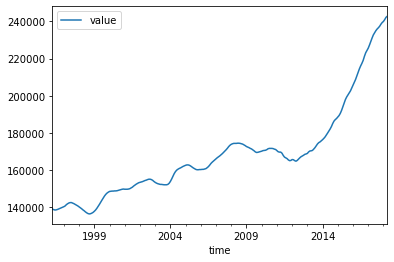

In [11]:
melt_data(austin_city[austin_city['RegionName'] == 78660]).plot();

In [12]:
# Melting data for each zipcode in Austin area:
df = pd.DataFrame()
for i in austin_city['RegionName']:
    x = melt_data(austin_city[austin_city['RegionName'] == i])  
    df = pd.concat([df, x], axis=1)
    df.rename(columns = {'value':i}, inplace = True)
# Look into the new dataframe
df

78660     78613     78704     78666     78745     78641  \
time                                                                     
1996-04-01  138900.0  169600.0  221300.0  103100.0  135000.0  153600.0   
1996-05-01  138600.0  169000.0  221100.0  103000.0  134200.0  152900.0   
1996-06-01  138400.0  168600.0  221000.0  103000.0  133800.0  152400.0   
1996-07-01  138500.0  168500.0  221000.0  103000.0  133800.0  152000.0   
1996-08-01  138700.0  168700.0  221300.0  103000.0  134000.0  151900.0   
...              ...       ...       ...       ...       ...       ...   
2017-12-01  239400.0  296200.0  539800.0  197500.0  290500.0  251200.0   
2018-01-01  240000.0  295900.0  540200.0  197900.0  291300.0  251900.0   
2018-02-01  241000.0  296400.0  542300.0  200100.0  292600.0  252800.0   
2018-03-01  242200.0  297500.0  547100.0  203800.0  294000.0  253700.0   
2018-04-01  242800.0  297300.0  550900.0  206500.0  294700.0  254100.0   

               78758     78741     78753     78759     78664     78748  \
time                                                                     
1996-04-01  129000.0   93800.0  111300.0  266400.0  133100.0  199500.0   
1996-05-01  128300.0   93600.0  110600.0  269000.0  132700.0  198800.0   
1996-06-01  127500.0   93500.0  109900.0  272000.0  132400.0  197900.0   
1996-07-01  126900.0   93400.0  109200.0  275100.0  132100.0  196700.0   
1996-08-01  126300.0   93400.0  108600.0  278200.0  131900.0  195100.0   
...              ...       ...       ...       ...       ...       ...   
2017-12-01  250500.0  238300.0  225000.0  442400.0  209600.0  276700.0   
2018-01-01  255100.0  241000.0  227100.0  443200.0  210400.0  277800.0   
2018-02-01  260100.0  243600.0  228700.0  445000.0  212100.0  279000.0   
2018-03-01  266000.0  247400.0  231500.0  449900.0  214900.0  280800.0   
2018-04-01  270400.0  250400.0  233400.0  454100.0  217300.0  282000.0   

               78681     78640     78665     78744     78749     78729  \
time                                                                     
1996-04-01  171000.0  112500.0  160700.0   85400.0  264000.0  163800.0   
1996-05-01  170900.0  111200.0  160300.0   85400.0  266400.0  163800.0   
1996-06-01  171000.0  110100.0  160100.0   85300.0  269300.0  163900.0   
1996-07-01  171500.0  109500.0  160200.0   85300.0  272400.0  164200.0   
1996-08-01  172300.0  109200.0  160500.0   85300.0  275500.0  164400.0   
...              ...       ...       ...       ...       ...       ...   
2017-12-01  291500.0  205100.0  258900.0  190900.0  348900.0  294000.0   
2018-01-01  292600.0  204900.0  258900.0  192100.0  349700.0  295800.0   
2018-02-01  293800.0  205700.0  259500.0  193200.0  352100.0  298600.0   
2018-03-01  295200.0  207800.0  260100.0  194500.0  355500.0  301600.0   
2018-04-01  296000.0  208900.0  259900.0  195500.0  357700.0  303300.0   

               78610     78723     78727     78717     78731     78628  \
time                                                                     
1996-04-01  149200.0   97600.0  150300.0  200800.0  351100.0  170900.0   
1996-05-01  148600.0   99000.0  150200.0  200400.0  349000.0  170800.0   
1996-06-01  148200.0  100300.0  150300.0  200500.0  347900.0  170800.0   
1996-07-01  148100.0  101400.0  150600.0  201100.0  347900.0  170900.0   
1996-08-01  148100.0  101900.0  151000.0  202300.0  349100.0  171100.0   
...              ...       ...       ...       ...       ...       ...   
2017-12-01  258000.0  352500.0  309300.0  355100.0  581700.0  308600.0   
2018-01-01  256900.0  355800.0  311800.0  356600.0  578400.0  309000.0   
2018-02-01  257200.0  358700.0  313400.0  359500.0  581900.0  310600.0   
2018-03-01  258900.0  361900.0  315200.0  362300.0  596700.0  313900.0   
2018-04-01  260000.0  364200.0  316500.0  363600.0  610500.0  316800.0   

               78705     78633     78703     78728     78750     78626  \
time                                                                     
1996-04-01  197

In [13]:
# # We will drop two zipcodes since they have missing values: 78616, 76530
# df.drop(columns=[78616, 76530], inplace=True)
# df

In [14]:
df_final = df[df.index.year > 2008]
df_final

78660     78613     78704     78666     78745     78641  \
time                                                                     
2009-01-01  172600.0  205300.0  366200.0  141500.0  172100.0  175900.0   
2009-02-01  172300.0  205000.0  365200.0  140700.0  172200.0  175400.0   
2009-03-01  172000.0  204700.0  363900.0  139800.0  172100.0  174900.0   
2009-04-01  171600.0  204600.0  362400.0  138900.0  171600.0  174500.0   
2009-05-01  171300.0  204300.0  361000.0  138100.0  171100.0  174200.0   
...              ...       ...       ...       ...       ...       ...   
2017-12-01  239400.0  296200.0  539800.0  197500.0  290500.0  251200.0   
2018-01-01  240000.0  295900.0  540200.0  197900.0  291300.0  251900.0   
2018-02-01  241000.0  296400.0  542300.0  200100.0  292600.0  252800.0   
2018-03-01  242200.0  297500.0  547100.0  203800.0  294000.0  253700.0   
2018-04-01  242800.0  297300.0  550900.0  206500.0  294700.0  254100.0   

               78758     78741     78753     78759     78664     78748  \
time                                                                     
2009-01-01  143400.0  144100.0  135000.0  307600.0  146600.0  186600.0   
2009-02-01  143400.0  143600.0  134900.0  307100.0  146200.0  186800.0   
2009-03-01  143500.0  143100.0  134700.0  306600.0  145800.0  186700.0   
2009-04-01  143400.0  142600.0  134500.0  306300.0  145200.0  186500.0   
2009-05-01  143300.0  142300.0  134200.0  305900.0  144500.0  186200.0   
...              ...       ...       ...       ...       ...       ...   
2017-12-01  250500.0  238300.0  225000.0  442400.0  209600.0  276700.0   
2018-01-01  255100.0  241000.0  227100.0  443200.0  210400.0  277800.0   
2018-02-01  260100.0  243600.0  228700.0  445000.0  212100.0  279000.0   
2018-03-01  266000.0  247400.0  231500.0  449900.0  214900.0  280800.0   
2018-04-01  270400.0  250400.0  233400.0  454100.0  217300.0  282000.0   

               78681     78640     78665     78744     78749     78729  \
time                                                                     
2009-01-01  203900.0  150600.0  192600.0  114400.0  231300.0  189700.0   
2009-02-01  203700.0  149900.0  191800.0  114500.0  231100.0  189700.0   
2009-03-01  203500.0  149300.0  191100.0  114400.0  230800.0  189400.0   
2009-04-01  203300.0  148800.0  190300.0  114300.0  230200.0  188900.0   
2009-05-01  203000.0  148200.0  189400.0  114200.0  229500.0  188500.0   
...              ...       ...       ...       ...       ...       ...   
2017-12-01  291500.0  205100.0  258900.0  190900.0  348900.0  294000.0   
2018-01-01  292600.0  204900.0  258900.0  192100.0  349700.0  295800.0   
2018-02-01  293800.0  205700.0  259500.0  193200.0  352100.0  298600.0   
2018-03-01  295200.0  207800.0  260100.0  194500.0  355500.0  301600.0   
2018-04-01  296000.0  208900.0  259900.0  195500.0  357700.0  303300.0   

               78610     78723     78727     78717     78731     78628  \
time                                                                     
2009-01-01  190200.0  205000.0  191400.0  250900.0  438900.0  231200.0   
2009-02-01  189500.0  205300.0  191100.0  250200.0  437400.0  230300.0   
2009-03-01  188800.0  205500.0  190700.0  249500.0  436000.0  229600.0   
2009-04-01  188100.0  206000.0  190200.0  248800.0  434400.0  229300.0   
2009-05-01  187500.0  206600.0  189600.0  248100.0  432200.0  228900.0   
...              ...       ...       ...       ...       ...       ...   
2017-12-01  258000.0  352500.0  309300.0  355100.0  581700.0  308600.0   
2018-01-01  256900.0  355800.0  311800.0  356600.0  578400.0  309000.0   
2018-02-01  257200.0  358700.0  313400.0  359500.0  581900.0  310600.0   
2018-03-01  258900.0  361900.0  315200.0  362300.0  596700.0  313900.0   
2018-04-01  260000.0  364200.0  316500.0  363600.0  610500.0  316800.0   

               78705     78633     78703     78728     78750     78626  \
time                                                                     
2009-01-01  407

In [15]:
df_final.isna().sum().sum()  # no missing values!

0

In [16]:
fig = px.line(df_final, title='Median House Prices')
fig.show()

# Step 3: EDA and Visualization

In [17]:
# Return for each zipcode!  
# Percentage change between the current and a prior element.
# (current homeprice - previous homeprice)/previous homeprice
df_return = df_final.pct_change()
df_return

78660     78613     78704     78666     78745     78641  \
time                                                                     
2009-01-01       NaN       NaN       NaN       NaN       NaN       NaN   
2009-02-01 -0.001738 -0.001461 -0.002731 -0.005654  0.000581 -0.002843   
2009-03-01 -0.001741 -0.001463 -0.003560 -0.006397 -0.000581 -0.002851   
2009-04-01 -0.002326 -0.000489 -0.004122 -0.006438 -0.002905 -0.002287   
2009-05-01 -0.001748 -0.001466 -0.003863 -0.005760 -0.002914 -0.001719   
...              ...       ...       ...       ...       ...       ...   
2017-12-01  0.003774  0.001352  0.002973  0.003047  0.002415  0.003997   
2018-01-01  0.002506 -0.001013  0.000741  0.002025  0.002754  0.002787   
2018-02-01  0.004167  0.001690  0.003887  0.011117  0.004463  0.003573   
2018-03-01  0.004979  0.003711  0.008851  0.018491  0.004785  0.003560   
2018-04-01  0.002477 -0.000672  0.006946  0.013248  0.002381  0.001577   

               78758     78741     78753     78759     78664     78748  \
time                                                                     
2009-01-01       NaN       NaN       NaN       NaN       NaN       NaN   
2009-02-01  0.000000 -0.003470 -0.000741 -0.001625 -0.002729  0.001072   
2009-03-01  0.000697 -0.003482 -0.001483 -0.001628 -0.002736 -0.000535   
2009-04-01 -0.000697 -0.003494 -0.001485 -0.000978 -0.004115 -0.001071   
2009-05-01 -0.000697 -0.002104 -0.002230 -0.001306 -0.004821 -0.001609   
...              ...       ...       ...       ...       ...       ...   
2017-12-01  0.010488  0.017941  0.008516  0.006827  0.004794  0.006548   
2018-01-01  0.018363  0.011330  0.009333  0.001808  0.003817  0.003975   
2018-02-01  0.019600  0.010788  0.007045  0.004061  0.008080  0.004320   
2018-03-01  0.022684  0.015599  0.012243  0.011011  0.013201  0.006452   
2018-04-01  0.016541  0.012126  0.008207  0.009335  0.011168  0.004274   

               78681     78640     78665     78744     78749     78729  \
time                                                                     
2009-01-01       NaN       NaN       NaN       NaN       NaN       NaN   
2009-02-01 -0.000981 -0.004648 -0.004154  0.000874 -0.000865  0.000000   
2009-03-01 -0.000982 -0.004003 -0.003650 -0.000873 -0.001298 -0.001581   
2009-04-01 -0.000983 -0.003349 -0.004186 -0.000874 -0.002600 -0.002640   
2009-05-01 -0.001476 -0.004032 -0.004729 -0.000875 -0.003041 -0.002118   
...              ...       ...       ...       ...       ...       ...   
2017-12-01  0.003442  0.000488  0.000000  0.006326  0.000574  0.009269   
2018-01-01  0.003774 -0.000975  0.000000  0.006286  0.002293  0.006122   
2018-02-01  0.004101  0.003904  0.002317  0.005726  0.006863  0.009466   
2018-03-01  0.004765  0.010209  0.002312  0.006729  0.009656  0.010047   
2018-04-01  0.002710  0.005294 -0.000769  0.005141  0.006188  0.005637   

               78610     78723     78727     78717     78731     78628  \
time                                                                     
2009-01-01       NaN       NaN       NaN       NaN       NaN       NaN   
2009-02-01 -0.003680  0.001463 -0.001567 -0.002790 -0.003418 -0.003893   
2009-03-01 -0.003694  0.000974 -0.002093 -0.002798 -0.003201 -0.003040   
2009-04-01 -0.003708  0.002433 -0.002622 -0.002806 -0.003670 -0.001307   
2009-05-01 -0.003190  0.002913 -0.003155 -0.002814 -0.005064 -0.001744   
...              ...       ...       ...       ...       ...       ...   
2017-12-01 -0.002706  0.013514  0.007820  0.001410  0.001033  0.002925   
2018-01-01 -0.004264  0.009362  0.008083  0.004224 -0.005673  0.001296   
2018-02-01  0.001168  0.008151  0.005131  0.008132  0.006051  0.005178   
2018-03-01  0.006610  0.008921  0.005743  0.007789  0.025434  0.010625   
2018-04-01  0.004249  0.006355  0.004124  0.003588  0.023127  0.009239   

               78705     78633     78703     78728     78750     78626  \
time                                                                     
2009-01-01     

In [18]:
# we will drop the first row of the df_return dataframe:
df_return.dropna(axis=0, inplace=True)

In [19]:
zcdb = ZipCodeDatabase()

In [20]:
austin_map = pd.DataFrame(data=df_return.mean())
austin_map.rename(columns = {0:'ReturnMean'}, inplace = True)
austin_map.drop(78633, axis=0, inplace=True)   # zipcode:78633 is missing in ZipCodeDatabase()

long = []
lat = []
cumsum = []
for i in austin_map.index:
    long.append(zcdb[i].longitude)
    lat.append(zcdb[i].latitude)
    cumsum.append(df_return[i].cumsum()[-1])
    
austin_map['long'] =long
austin_map['lat']=lat
austin_map['CumulativeReturn'] = cumsum

austin_map = austin_map.reset_index()
austin_map.rename(columns = {'index':'Zipcode'}, inplace = True)
austin_map

Zipcode  ReturnMean      long        lat  CumulativeReturn
0     78660    0.003087 -97.62300  30.450122          0.342633
1     78613    0.003351 -97.83087  30.501272          0.371961
2     78704    0.003696 -97.76087  30.246309          0.410218
3     78666    0.003428 -97.94668  29.876944          0.380476
4     78745    0.004874 -97.79575  30.207559          0.540987
..      ...         ...       ...        ...               ...
67    78652    0.004241 -97.84380  30.128480          0.470794
68    78619    0.002679 -98.03875  30.103644          0.297378
69    78659    0.004917 -97.11662  30.210685          0.545745
70    78655    0.003695 -97.84178  29.838163          0.410190
71    76530    0.003737 -97.43449  30.715207          0.414755

[72 rows x 5 columns]

In [21]:
# Explore relationship between percent return and zipcode
fig = px.scatter_mapbox(data_frame = austin_map, # df name
                        lat='lat', # name of latitude column
                        lon='long', # name of longitude column
                        color='CumulativeReturn', # name of column to use for the color
                        zoom=7.5)

fig.update_layout(mapbox_style="open-street-map")
fig.show()

In [22]:
#[Latitude ,Longitude]
Austin = folium.Map(location=[30.267153, -97.7430608])

tooltip = "Austin!"
folium.Marker(
    [30.267153, -97.7430608], popup="<i>TestClick</i>", tooltip=tooltip
).add_to(Austin)


Austin

# Step 4: ARIMA Modeling

In [23]:
# Our final dataset for the time series analysis:
df_final

78660     78613     78704     78666     78745     78641  \
time                                                                     
2009-01-01  172600.0  205300.0  366200.0  141500.0  172100.0  175900.0   
2009-02-01  172300.0  205000.0  365200.0  140700.0  172200.0  175400.0   
2009-03-01  172000.0  204700.0  363900.0  139800.0  172100.0  174900.0   
2009-04-01  171600.0  204600.0  362400.0  138900.0  171600.0  174500.0   
2009-05-01  171300.0  204300.0  361000.0  138100.0  171100.0  174200.0   
...              ...       ...       ...       ...       ...       ...   
2017-12-01  239400.0  296200.0  539800.0  197500.0  290500.0  251200.0   
2018-01-01  240000.0  295900.0  540200.0  197900.0  291300.0  251900.0   
2018-02-01  241000.0  296400.0  542300.0  200100.0  292600.0  252800.0   
2018-03-01  242200.0  297500.0  547100.0  203800.0  294000.0  253700.0   
2018-04-01  242800.0  297300.0  550900.0  206500.0  294700.0  254100.0   

               78758     78741     78753     78759     78664     78748  \
time                                                                     
2009-01-01  143400.0  144100.0  135000.0  307600.0  146600.0  186600.0   
2009-02-01  143400.0  143600.0  134900.0  307100.0  146200.0  186800.0   
2009-03-01  143500.0  143100.0  134700.0  306600.0  145800.0  186700.0   
2009-04-01  143400.0  142600.0  134500.0  306300.0  145200.0  186500.0   
2009-05-01  143300.0  142300.0  134200.0  305900.0  144500.0  186200.0   
...              ...       ...       ...       ...       ...       ...   
2017-12-01  250500.0  238300.0  225000.0  442400.0  209600.0  276700.0   
2018-01-01  255100.0  241000.0  227100.0  443200.0  210400.0  277800.0   
2018-02-01  260100.0  243600.0  228700.0  445000.0  212100.0  279000.0   
2018-03-01  266000.0  247400.0  231500.0  449900.0  214900.0  280800.0   
2018-04-01  270400.0  250400.0  233400.0  454100.0  217300.0  282000.0   

               78681     78640     78665     78744     78749     78729  \
time                                                                     
2009-01-01  203900.0  150600.0  192600.0  114400.0  231300.0  189700.0   
2009-02-01  203700.0  149900.0  191800.0  114500.0  231100.0  189700.0   
2009-03-01  203500.0  149300.0  191100.0  114400.0  230800.0  189400.0   
2009-04-01  203300.0  148800.0  190300.0  114300.0  230200.0  188900.0   
2009-05-01  203000.0  148200.0  189400.0  114200.0  229500.0  188500.0   
...              ...       ...       ...       ...       ...       ...   
2017-12-01  291500.0  205100.0  258900.0  190900.0  348900.0  294000.0   
2018-01-01  292600.0  204900.0  258900.0  192100.0  349700.0  295800.0   
2018-02-01  293800.0  205700.0  259500.0  193200.0  352100.0  298600.0   
2018-03-01  295200.0  207800.0  260100.0  194500.0  355500.0  301600.0   
2018-04-01  296000.0  208900.0  259900.0  195500.0  357700.0  303300.0   

               78610     78723     78727     78717     78731     78628  \
time                                                                     
2009-01-01  190200.0  205000.0  191400.0  250900.0  438900.0  231200.0   
2009-02-01  189500.0  205300.0  191100.0  250200.0  437400.0  230300.0   
2009-03-01  188800.0  205500.0  190700.0  249500.0  436000.0  229600.0   
2009-04-01  188100.0  206000.0  190200.0  248800.0  434400.0  229300.0   
2009-05-01  187500.0  206600.0  189600.0  248100.0  432200.0  228900.0   
...              ...       ...       ...       ...       ...       ...   
2017-12-01  258000.0  352500.0  309300.0  355100.0  581700.0  308600.0   
2018-01-01  256900.0  355800.0  311800.0  356600.0  578400.0  309000.0   
2018-02-01  257200.0  358700.0  313400.0  359500.0  581900.0  310600.0   
2018-03-01  258900.0  361900.0  315200.0  362300.0  596700.0  313900.0   
2018-04-01  260000.0  364200.0  316500.0  363600.0  610500.0  316800.0   

               78705     78633     78703     78728     78750     78626  \
time                                                                     
2009-01-01  407

#### Choose a representative zipcode for analysis -  ZIPCODE: 78660 

In [24]:
# Representative zipcode:
df_final[78660]

time
2009-01-01    172600.0
2009-02-01    172300.0
2009-03-01    172000.0
2009-04-01    171600.0
2009-05-01    171300.0
                ...   
2017-12-01    239400.0
2018-01-01    240000.0
2018-02-01    241000.0
2018-03-01    242200.0
2018-04-01    242800.0
Freq: MS, Name: 78660, Length: 112, dtype: float64

In [25]:
# Let's  get the rolling mean and rolling standard deviation, using a 12-month window

roll_mean = df_final[78660].rolling(window=12, center=False).mean()
roll_std = df_final[78660].rolling(window=12, center=False).std()

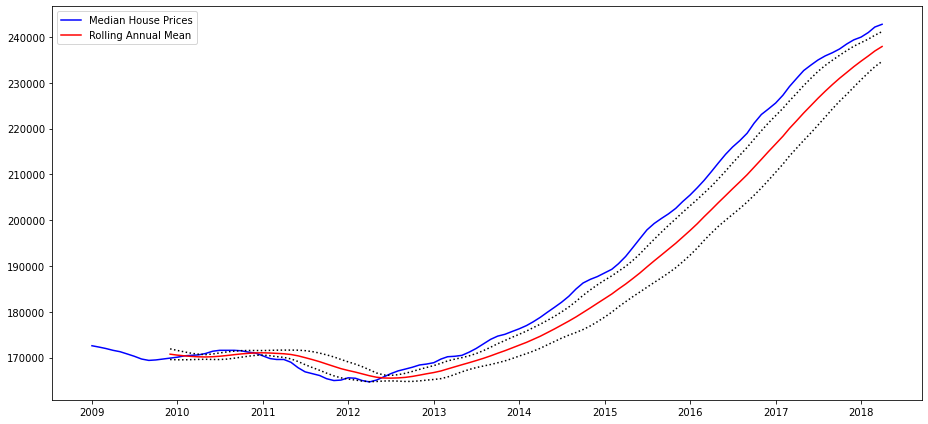

In [26]:
fig, ax = plt.subplots(figsize=(13, 6))
ax.plot(df_final[78660], color='blue',
        label='Median House Prices')

ax.plot(roll_mean, color='red', label='Rolling Annual Mean')

ax.plot(roll_mean + roll_std, color='black', linestyle='dotted')
ax.plot(roll_mean - roll_std, color='black', linestyle='dotted')

ax.legend()
fig.tight_layout()

 - Data is not stationary, it has upward trend!

In [27]:
# Stationarty test for original data:
adfuller(df_final[78660])

(-1.616734964272167,
 0.47444144079205,
 11,
 100,
 {'1%': -3.497501033, '5%': -2.89090644, '10%': -2.5824349},
 1357.6474504418627)

In [28]:
# Taking the log transform:
adfuller(np.log(df_final[78660]))

(-1.441206708276351,
 0.562369562961611,
 8,
 103,
 {'1%': -3.4954932834550623,
  '5%': -2.8900369024285117,
  '10%': -2.5819706975209726},
 -1020.7650495171713)

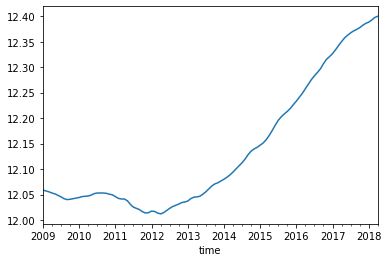

In [29]:
np.log(df_final[78660]).plot();

In [30]:
# Taking difference to make data stationary:
diff_df = df_final[78660].diff(periods=2).dropna()
adfuller(diff_df)

(-1.4754947172637727,
 0.5455970566430592,
 6,
 103,
 {'1%': -3.4954932834550623,
  '5%': -2.8900369024285117,
  '10%': -2.5819706975209726},
 1337.7605638948364)

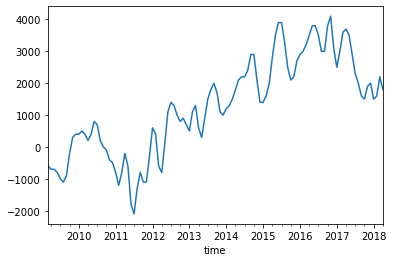

In [31]:
diff_df.plot();

In [32]:
# Subtacting rolling average:
df_minus_roll_mean = df_final[78660] - roll_mean
df_minus_roll_mean.dropna(inplace=True)
adfuller(df_minus_roll_mean)

(-1.5872132392944176,
 0.49001348828959385,
 11,
 89,
 {'1%': -3.506057133647011,
  '5%': -2.8946066061911946,
  '10%': -2.5844100201994697},
 1189.4624787469465)

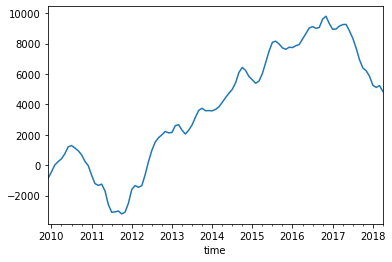

In [33]:
df_minus_roll_mean.plot();

In [34]:
# Weighted rolling mean:
exp_roll_mean = df_final[78660].ewm(halflife=2).mean()
adfuller(df_final[78660] - exp_roll_mean)

(-1.4135718541792763,
 0.5757525843269407,
 11,
 100,
 {'1%': -3.497501033, '5%': -2.89090644, '10%': -2.5824349},
 1291.6628131993523)

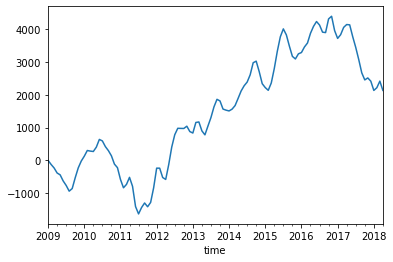

In [35]:
(df_final[78660] - exp_roll_mean).plot();

In [130]:
def log_transform(series):
    log_transformed = np.log(series)
    return log_transformed

In [131]:
def run_auto_arima(series):
    
    gridsearch = pm.auto_arima(series,
                            start_p = 0,
                            max_p = 3,
                            d = 0, 
                            max_d = 3, 
                            start_q = 0,
                            max_q = 3,
                            seasonal=True,
                            m = 12,
                            suppress_warnings=True)
    
    model = ARIMA(series, 
                  order = gridsearch.order, 
                  seasonal_order = gridsearch.seasonal_order,
                  enforce_stationarity=False)

    
    return model.fit()

In [132]:
# Function is from Centaur Group:
def run_arima_model(series, start, end):
    
    log_row_series = log_transform(series)
    
    model = run_auto_arima(log_row_series)
    
    log_prediction = model.predict(start, end)
    
    prediction = np.e ** log_prediction
    
    prediction_df = pd.DataFrame(prediction.values, prediction.index)
    
    return series, prediction_df

- We have 112 months in our series  for each zipcode.
- We want to forecast 12 more months.
- End date = 124

In [134]:
original_series, prediction_series = run_arima_model(df_final[78660], 0, 124)

C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.

C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [135]:
original_series

time
2009-01-01    172600.0
2009-02-01    172300.0
2009-03-01    172000.0
2009-04-01    171600.0
2009-05-01    171300.0
                ...   
2017-12-01    239400.0
2018-01-01    240000.0
2018-02-01    241000.0
2018-03-01    242200.0
2018-04-01    242800.0
Freq: MS, Name: 78660, Length: 112, dtype: float64

In [136]:
prediction_series

0
2009-01-01  141036.323055
2009-02-01  173067.056886
2009-03-01  172762.223565
2009-04-01  172457.397345
2009-05-01  172050.973453
...                   ...
2019-01-01  257883.680244
2019-02-01  259985.010937
2019-03-01  262133.853183
2019-04-01  264330.769587
2019-05-01  266573.961859

[125 rows x 1 columns]

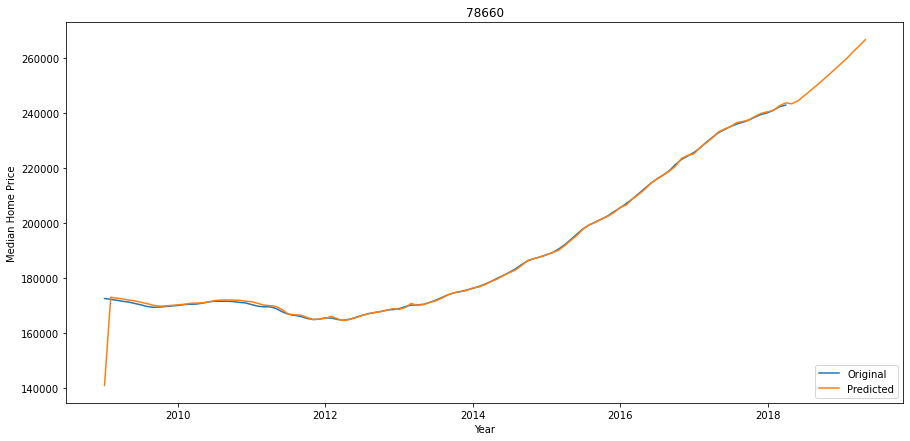

In [137]:
fig, ax = plt.subplots(figsize=(15, 7))
plt.plot(original_series)
plt.plot(prediction_series)
plt.title('78660')
plt.legend(['Original','Predicted'], loc='lower right')
plt.xlabel('Year')
plt.ylabel('Median Home Price')
plt.show()

In [138]:
# metrics  - Copy from TS review
def report_metrics(y_true, y_pred):
    print("Explained Variance:\n\t", metrics.explained_variance_score(y_true, y_pred))
    print("MAE:\n\t", metrics.mean_absolute_error(y_true, y_pred))
    print("RMSE:\n\t", metrics.mean_squared_error(y_true, y_pred, squared=False))
    print("r^2:\n\t", metrics.r2_score(y_true, y_pred))
    

report_metrics(original_series, prediction_series[:-13])   

Explained Variance:
	 0.9851780514957951
MAE:
	 585.7589716749595
RMSE:
	 3009.449792954778
r^2:
	 0.9851408514552862


### Forecasting all zipcodes in Austin area:

C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.

C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



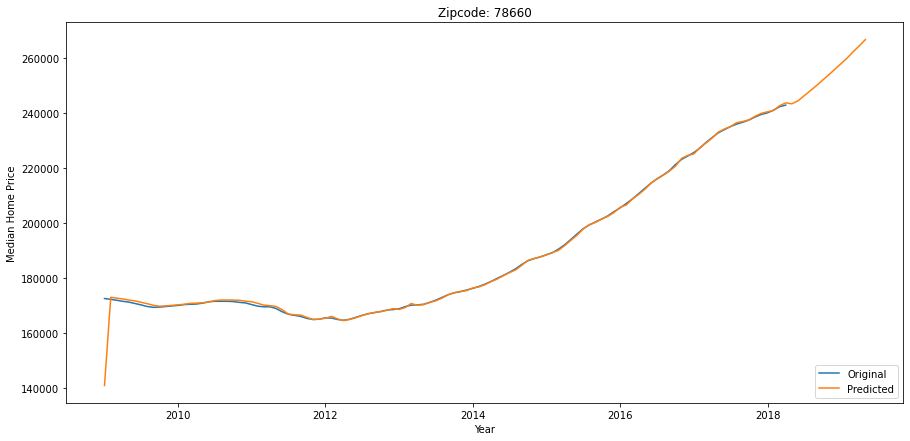

Zipcode: 78660
Explained Variance:
	 0.9851780514957951
MAE:
	 585.7589716749595
RMSE:
	 3009.449792954778
r^2:
	 0.9851408514552862


C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



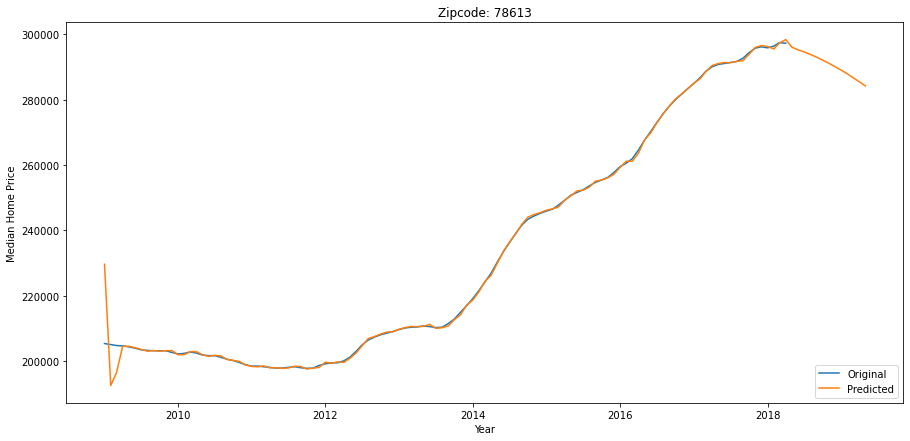

Zipcode: 78613
Explained Variance:
	 0.9937824985131611
MAE:
	 675.5204134357767
RMSE:
	 2724.94602294823
r^2:
	 0.9937824384321752


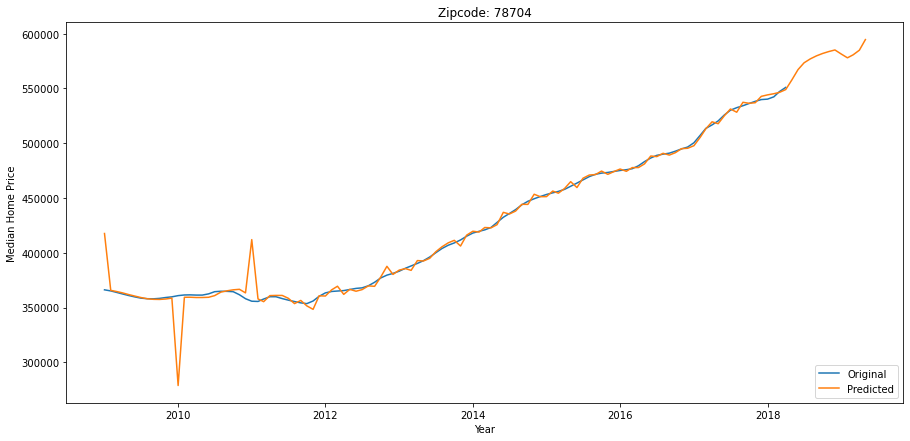

Zipcode: 78704
Explained Variance:
	 0.9703210955914139
MAE:
	 3535.2408616834396
RMSE:
	 10838.291183198293
r^2:
	 0.9703115333917003


C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.

C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



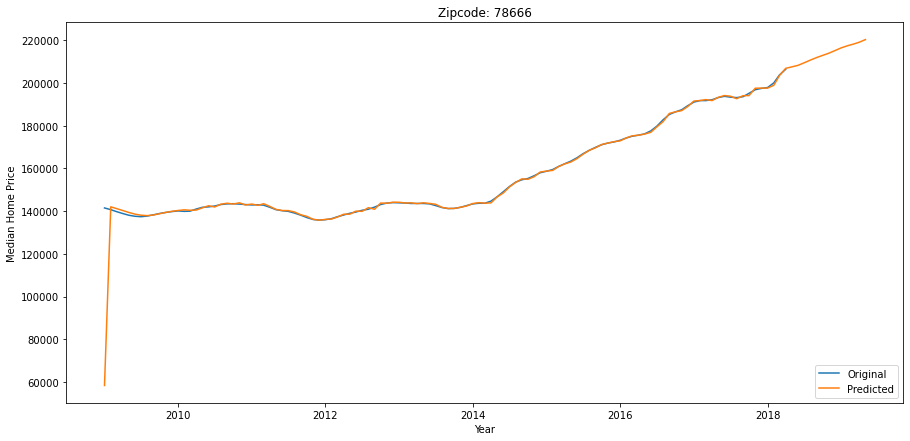

Zipcode: 78666
Explained Variance:
	 0.8607745794849367
MAE:
	 1100.9436462411893
RMSE:
	 7874.551633613897
r^2:
	 0.859763874560113


C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



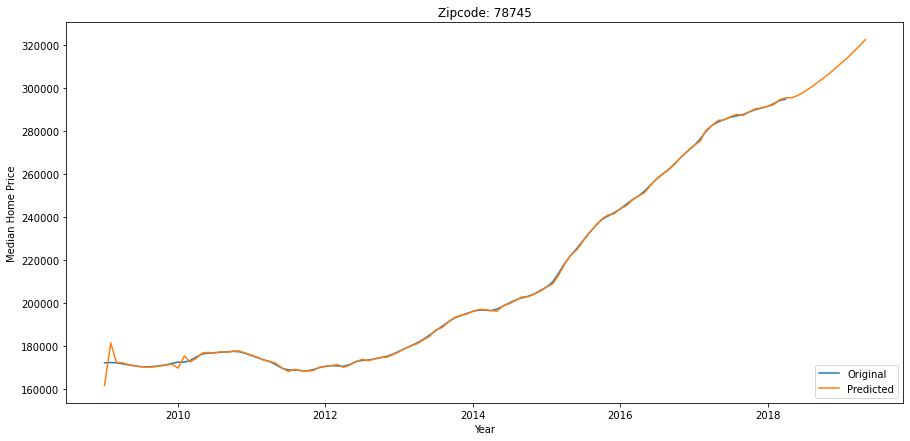

Zipcode: 78745
Explained Variance:
	 0.9988710063062203
MAE:
	 517.6918265802991
RMSE:
	 1425.9161943461656
r^2:
	 0.9988681510950761


C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



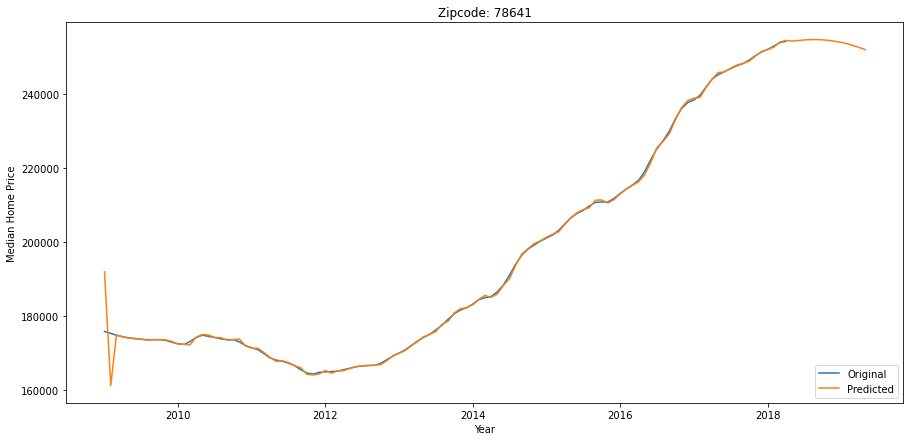

Zipcode: 78641
Explained Variance:
	 0.9949094187107295
MAE:
	 507.529549774672
RMSE:
	 2044.0623088889167
r^2:
	 0.994909379823888


C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.

C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



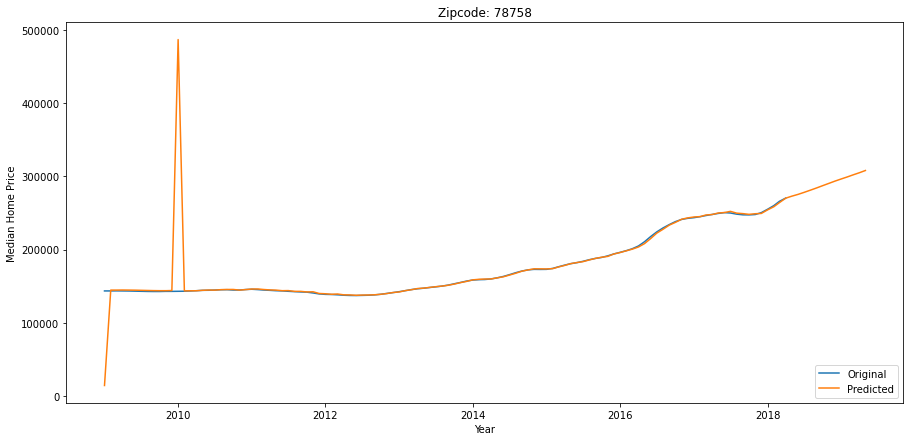

Zipcode: 78758
Explained Variance:
	 0.272880851892383
MAE:
	 4851.015922275427
RMSE:
	 34766.403522699344
r^2:
	 0.2702581589876397


C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.

C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



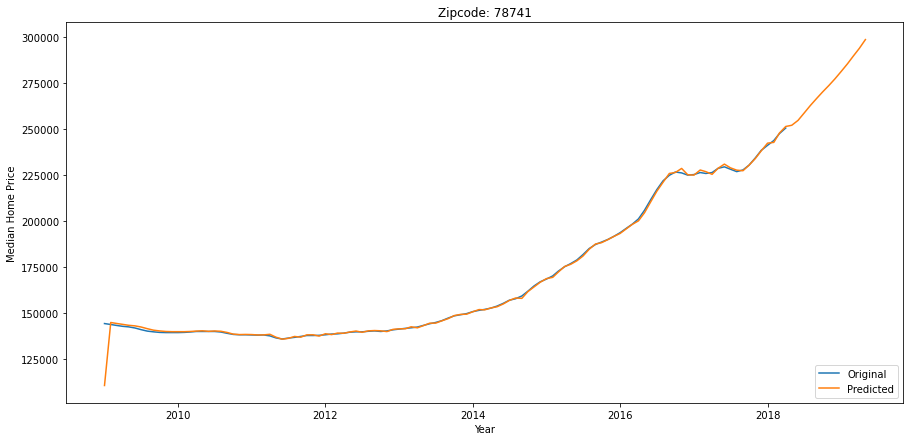

Zipcode: 78741
Explained Variance:
	 0.9918727293521981
MAE:
	 784.6961172179246
RMSE:
	 3244.770810565981
r^2:
	 0.9918472347306099


C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\pmdarima\arima\_auto_solvers.py:522: ModelFitWarning:

Error fitting  ARIMA(2,0,3)(1,0,2)[12] intercept (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\pmdarima\arima\_auto_solvers.py", line 506, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\pmdarima\arima\arima.py", line 597, in fit
    self._fit(y, X, **fit_args)
  File "C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\pmdarima\arima\arima.py", line 518, in _fit
    fit, self.arima_res_ = _fit_wrapper()
  File "C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\pmdarima\arima\arima.py", line 508, in _fit_wrapper
    return arima, arima.fit(start_params=start_params,
  File "C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\

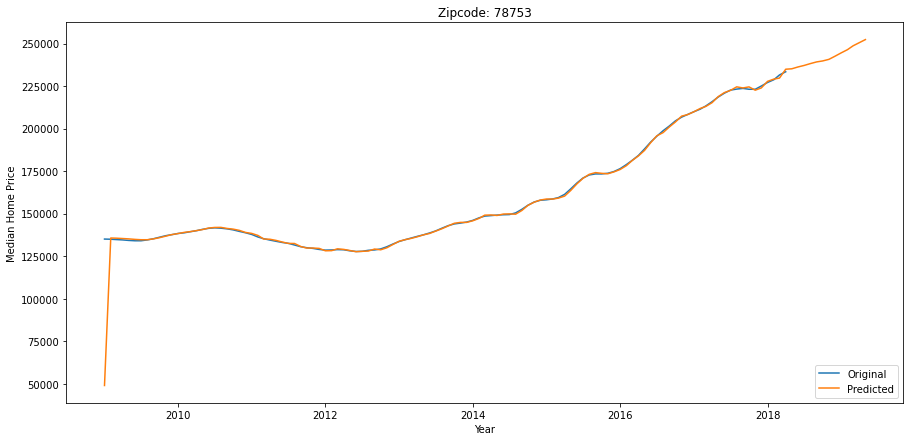

Zipcode: 78753
Explained Variance:
	 0.9366873458749047
MAE:
	 1188.345549258245
RMSE:
	 8155.335304090298
r^2:
	 0.9361775873738143


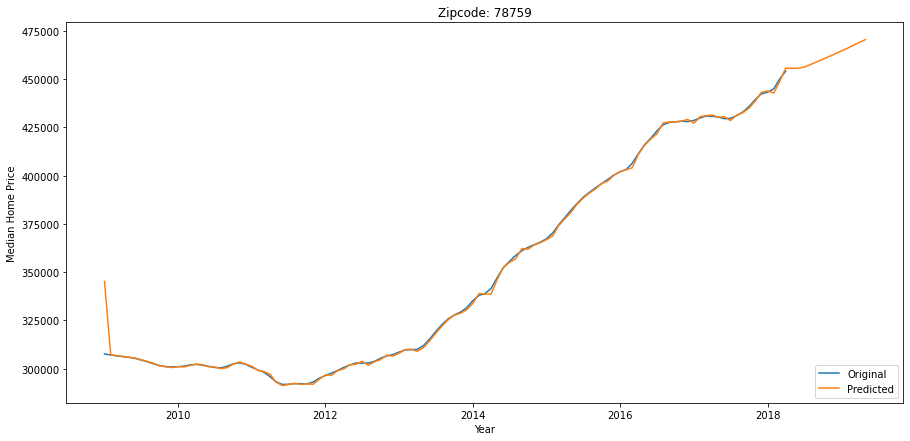

Zipcode: 78759
Explained Variance:
	 0.9954527291878451
MAE:
	 919.0033687016528
RMSE:
	 3636.884775879584
r^2:
	 0.9954514775449943


C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



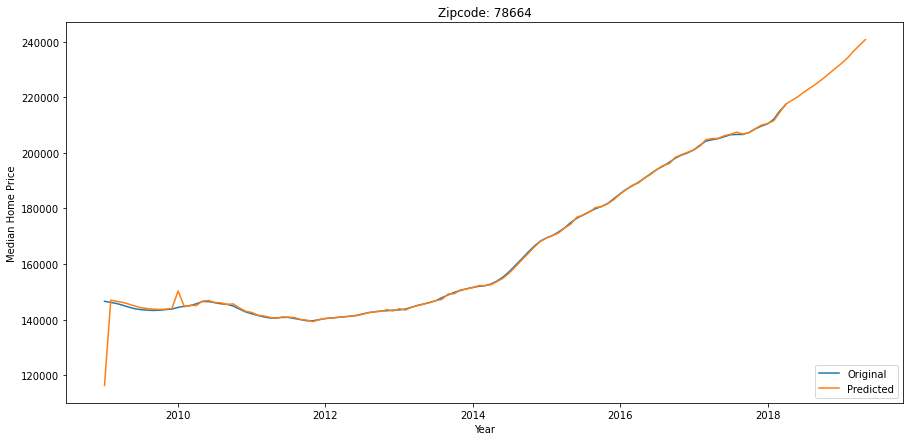

Zipcode: 78664
Explained Variance:
	 0.9860349324494786
MAE:
	 591.9388984493526
RMSE:
	 2937.964764021816
r^2:
	 0.9859970716380665


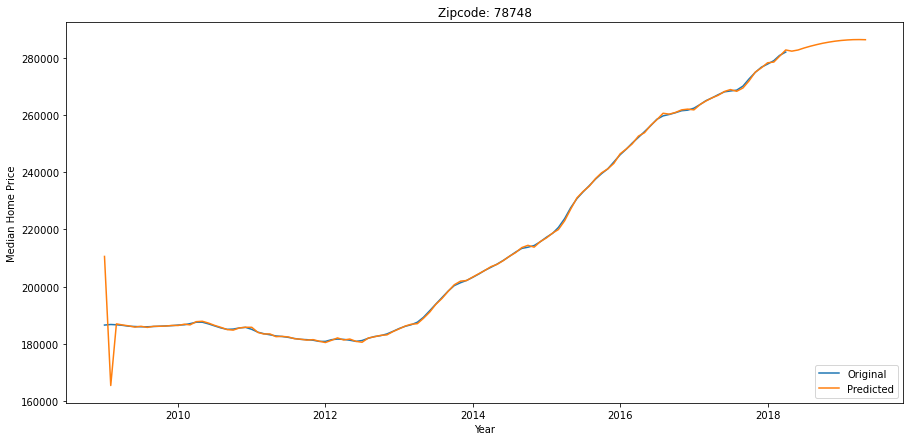

Zipcode: 78748
Explained Variance:
	 0.9918278325730793
MAE:
	 649.531112683774
RMSE:
	 3049.006562259822
r^2:
	 0.9918277448227579


C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.

C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



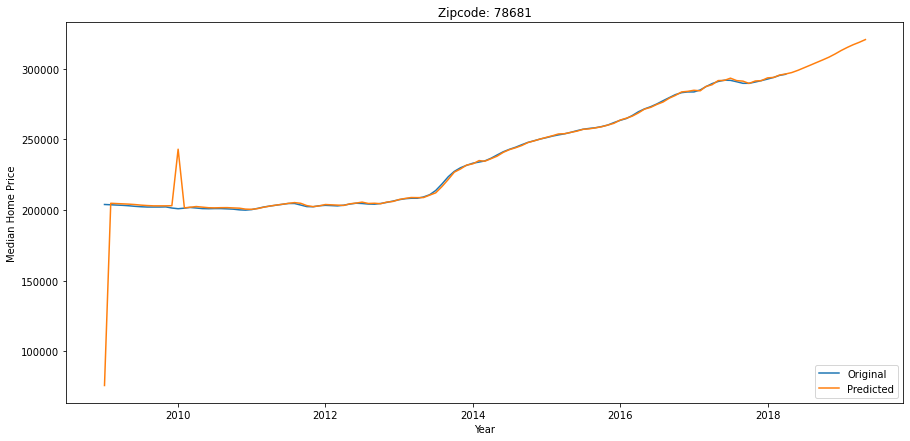

Zipcode: 78681
Explained Variance:
	 0.8604353549164186
MAE:
	 2049.2122391412354
RMSE:
	 12753.643526372396
r^2:
	 0.8601426463154243


C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



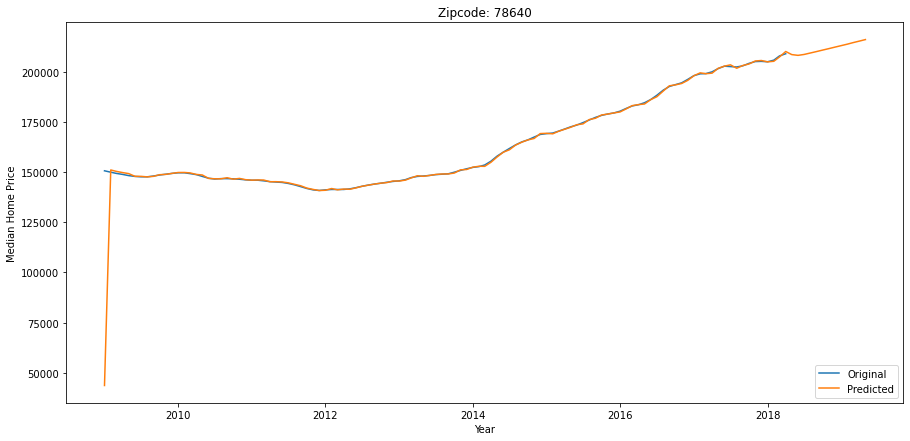

Zipcode: 78640
Explained Variance:
	 0.7855523002500778
MAE:
	 1232.1442020170814
RMSE:
	 10110.945442763663
r^2:
	 0.7837039113501448


C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



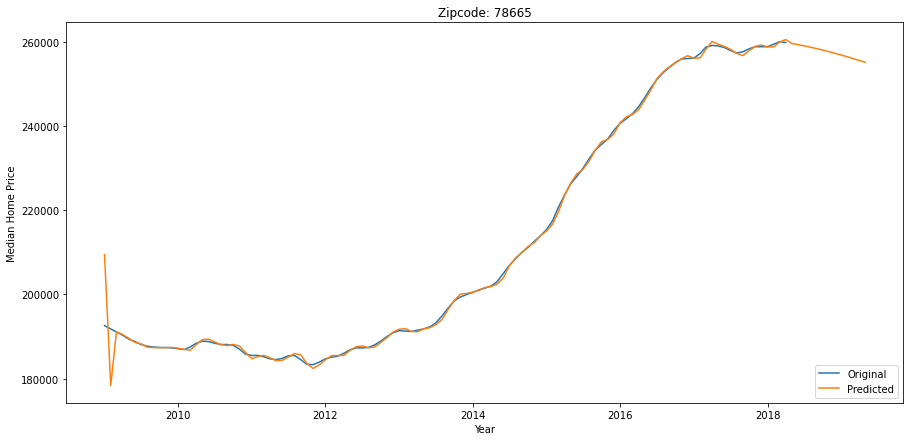

Zipcode: 78665
Explained Variance:
	 0.9945715212337444
MAE:
	 610.8206767893656
RMSE:
	 2085.5849999641086
r^2:
	 0.9945708334084506


C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



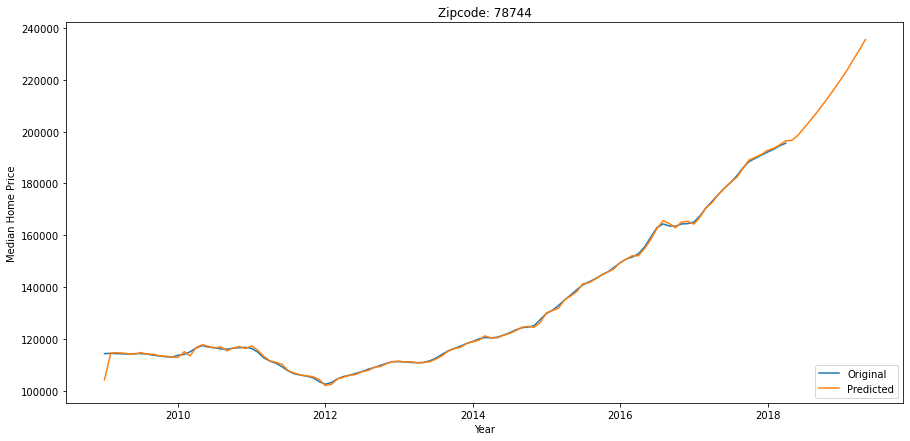

Zipcode: 78744
Explained Variance:
	 0.9983653653250207
MAE:
	 471.1659608119579
RMSE:
	 1075.6443536727438
r^2:
	 0.9983534609813149


C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



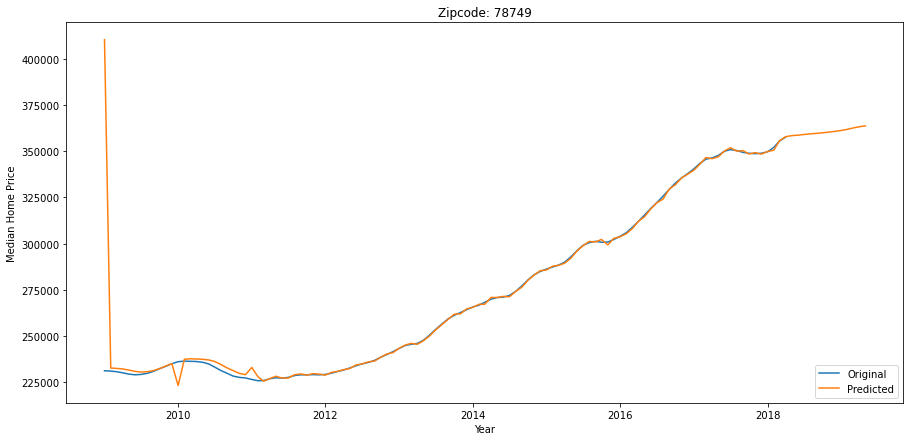

Zipcode: 78749
Explained Variance:
	 0.8523550157129292
MAE:
	 2458.8024482660103
RMSE:
	 17007.25578240807
r^2:
	 0.8506461453451671


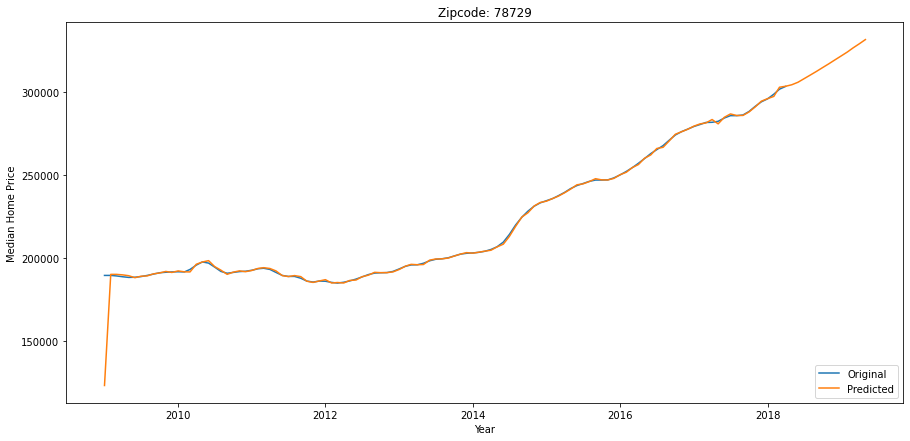

Zipcode: 78729
Explained Variance:
	 0.9720780613550365
MAE:
	 1005.9394161512867
RMSE:
	 6276.009116559161
r^2:
	 0.9718522294140658


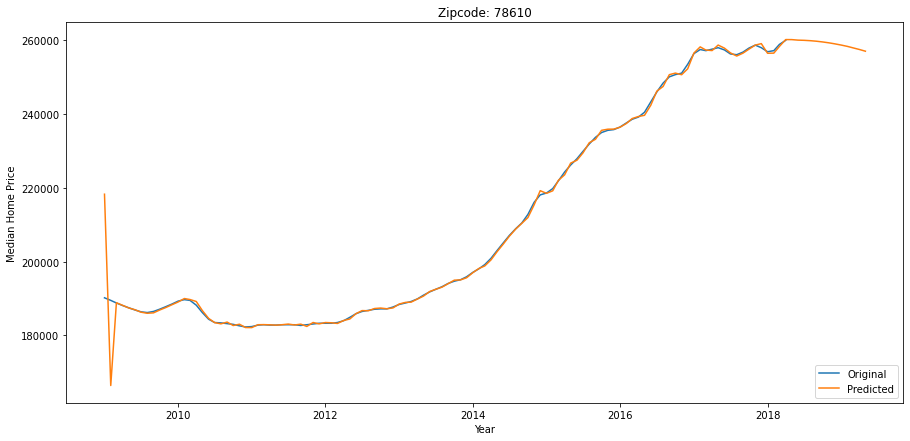

Zipcode: 78610
Explained Variance:
	 0.9850156582432085
MAE:
	 758.5817048285836
RMSE:
	 3457.973867806427
r^2:
	 0.9850155717270445


C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



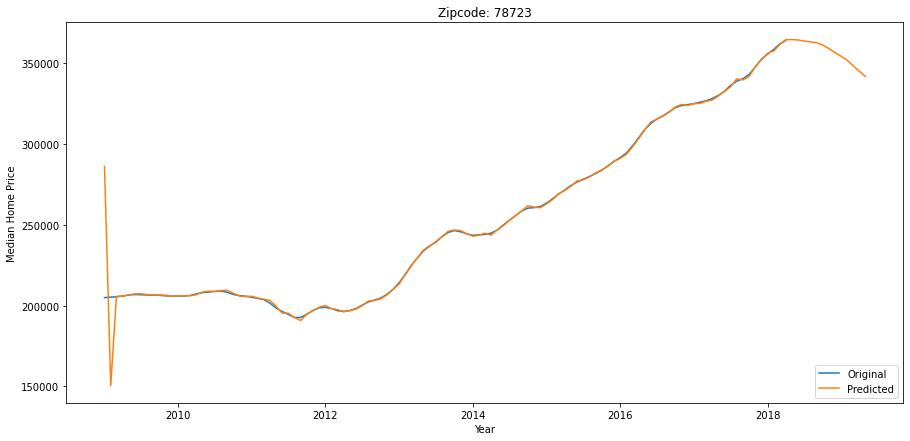

Zipcode: 78723
Explained Variance:
	 0.9683376823964795
MAE:
	 1656.2908425516628
RMSE:
	 9270.09216101447
r^2:
	 0.9683153721810855


C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



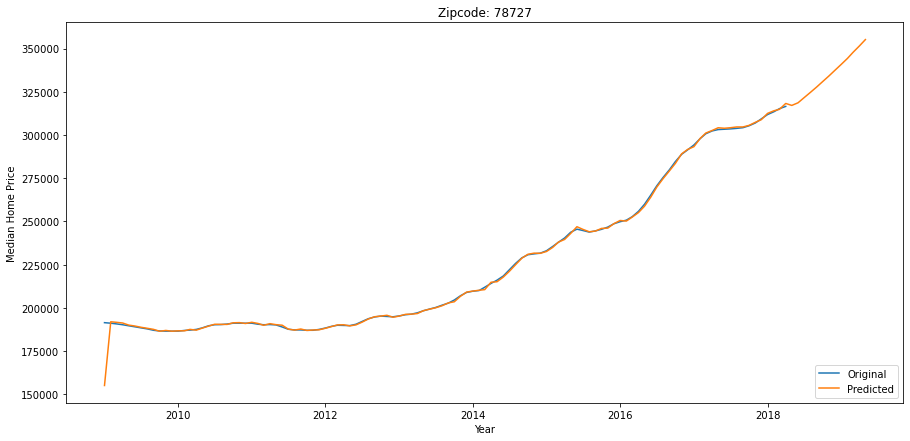

Zipcode: 78727
Explained Variance:
	 0.9933685184235423
MAE:
	 759.6854115508377
RMSE:
	 3478.622172664568
r^2:
	 0.9933187357885099


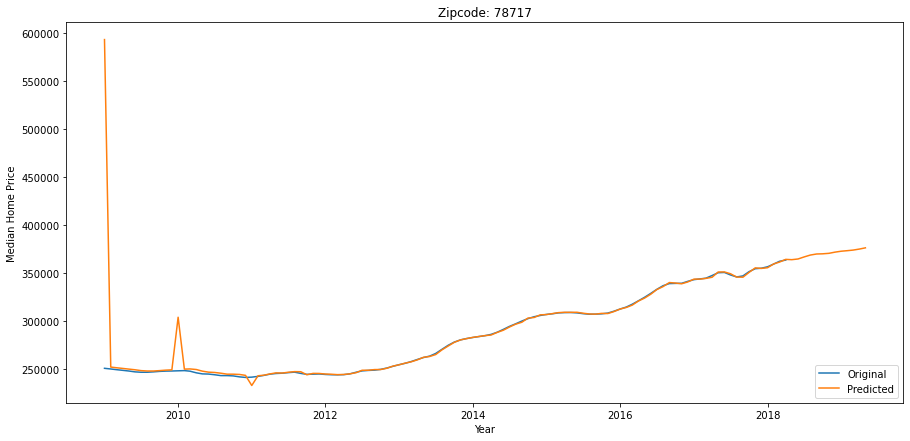

Zipcode: 78717
Explained Variance:
	 0.3438731319492567
MAE:
	 4387.683832141599
RMSE:
	 32791.02981504442
r^2:
	 0.3348372927209756


C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



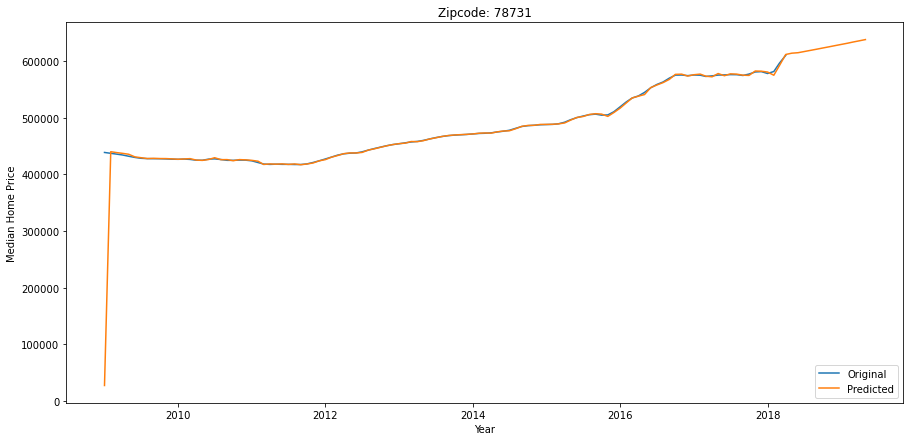

Zipcode: 78731
Explained Variance:
	 0.5418507259195988
MAE:
	 4610.087128487213
RMSE:
	 38928.16367294189
r^2:
	 0.5378684253210579


C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



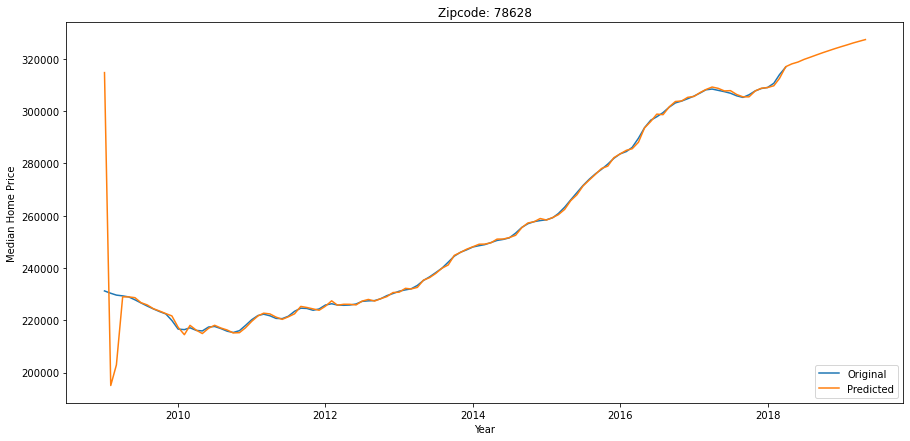

Zipcode: 78628
Explained Variance:
	 0.9268630451089435
MAE:
	 1728.7131868179688
RMSE:
	 8945.923764753852
r^2:
	 0.926832070830869


C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



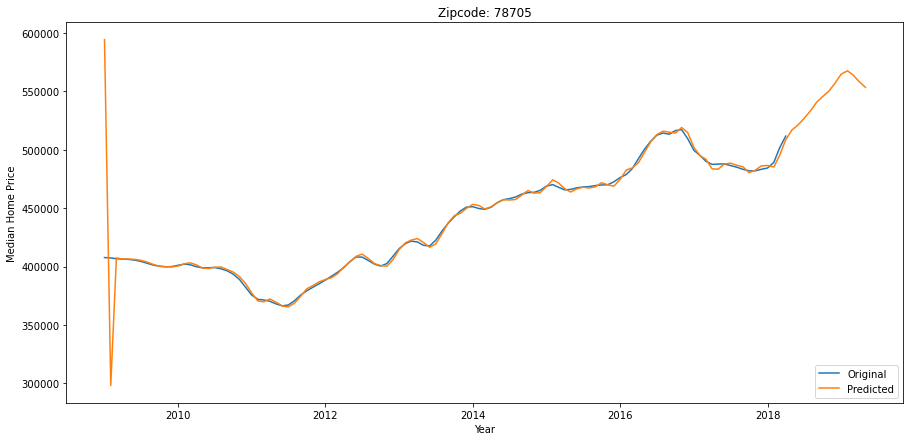

Zipcode: 78705
Explained Variance:
	 0.7816743848609415
MAE:
	 4158.934830753328
RMSE:
	 20506.471112800886
r^2:
	 0.7813350235045586


C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



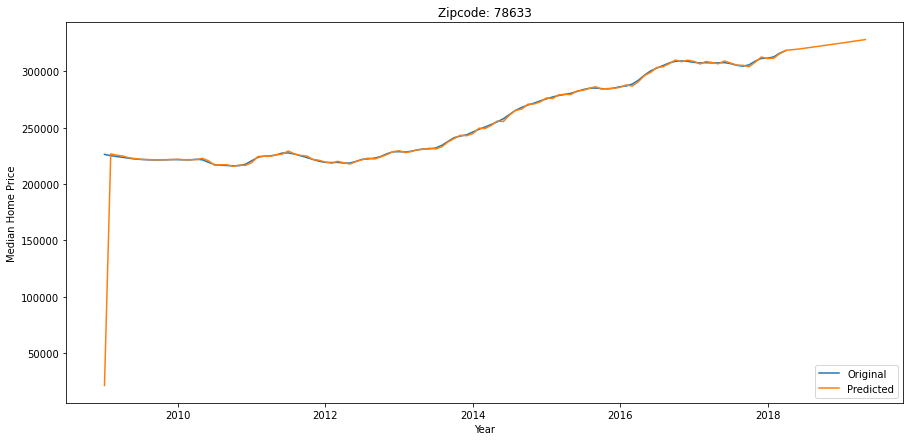

Zipcode: 78633
Explained Variance:
	 0.7024914760321699
MAE:
	 2546.6142011710886
RMSE:
	 19406.11561767424
r^2:
	 0.6996555320384201


C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



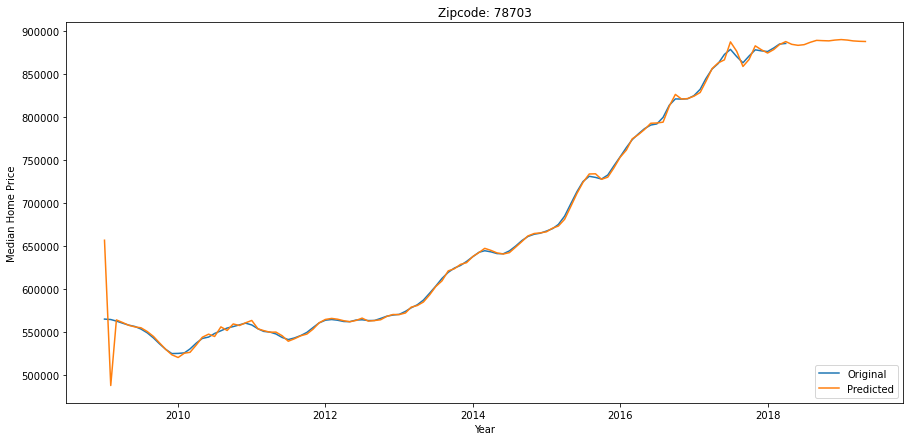

Zipcode: 78703
Explained Variance:
	 0.9903755345064141
MAE:
	 3245.783999847758
RMSE:
	 11545.443143700588
r^2:
	 0.9903755338798591


C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



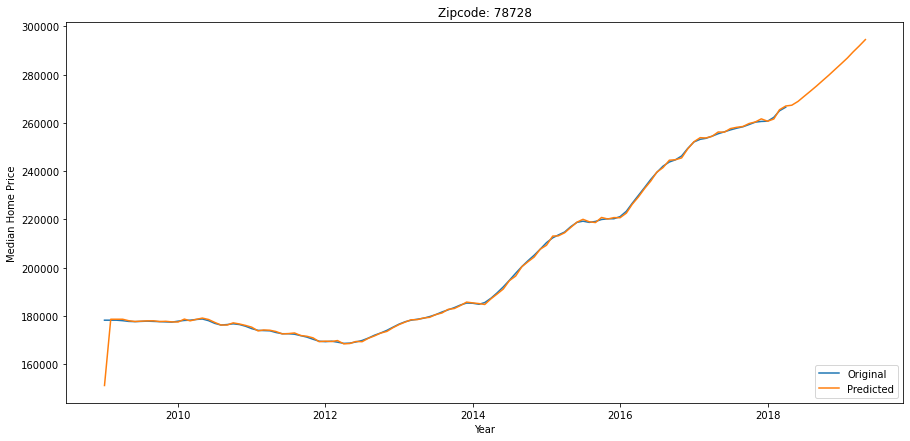

Zipcode: 78728
Explained Variance:
	 0.9933436802732646
MAE:
	 585.5812262275659
RMSE:
	 2591.3292068559
r^2:
	 0.9932912540382188


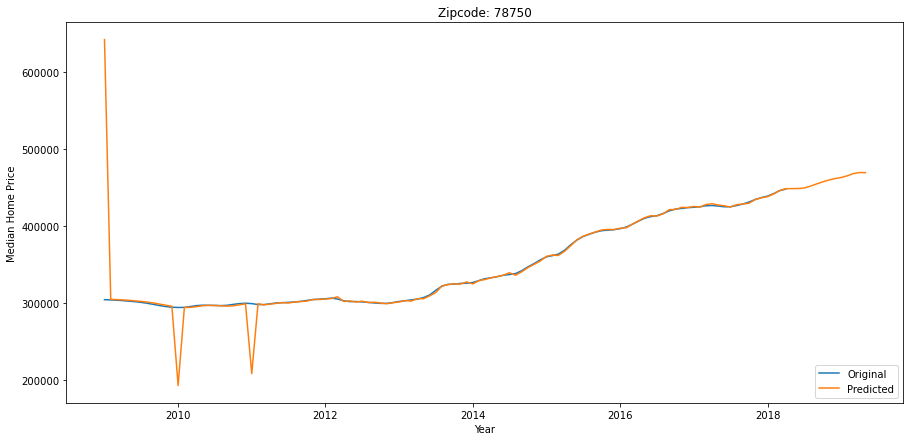

Zipcode: 78750
Explained Variance:
	 0.5650356834994976
MAE:
	 5554.653260559883
RMSE:
	 34398.150260173104
r^2:
	 0.5644029417321977


C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.

C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



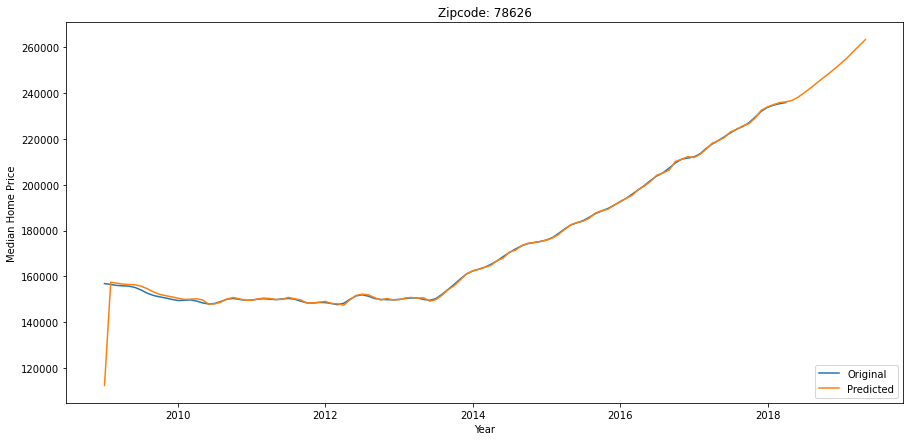

Zipcode: 78626
Explained Variance:
	 0.9768635999612562
MAE:
	 772.9853650927241
RMSE:
	 4231.801343239501
r^2:
	 0.9767831145519353


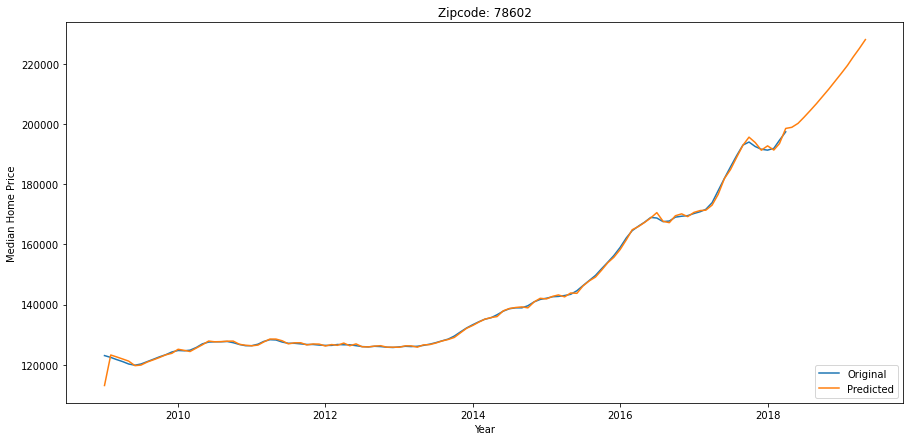

Zipcode: 78602
Explained Variance:
	 0.9977222764335799
MAE:
	 456.9911823162056
RMSE:
	 1070.1225500532933
r^2:
	 0.9977115718118124


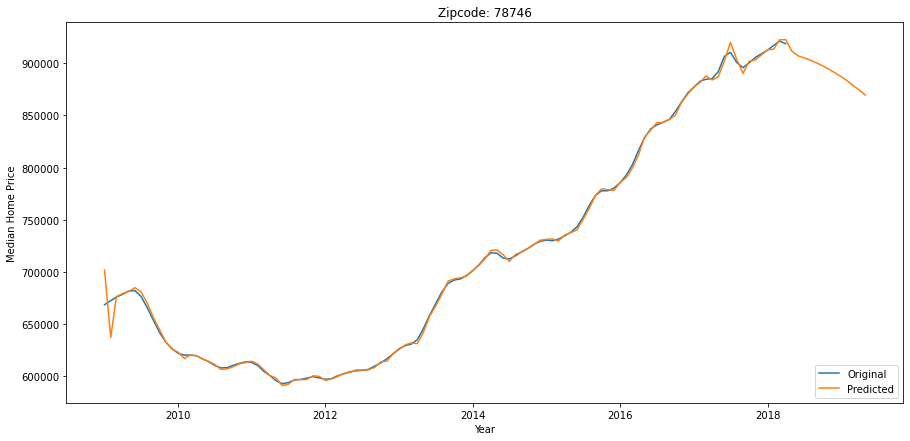

Zipcode: 78746
Explained Variance:
	 0.9977104062783297
MAE:
	 2178.2701421975767
RMSE:
	 5055.520405391022
r^2:
	 0.9977093024869012


C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



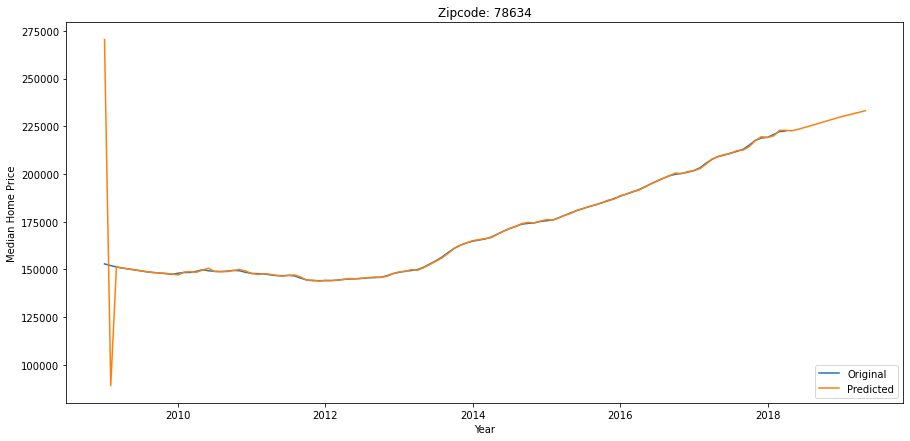

Zipcode: 78634
Explained Variance:
	 0.7364369902513526
MAE:
	 1857.9819790505994
RMSE:
	 12592.864742481857
r^2:
	 0.7360042682369625


C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



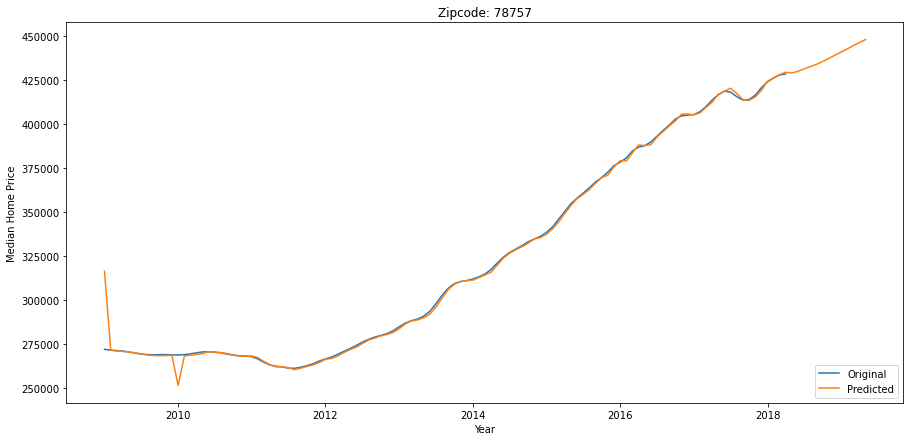

Zipcode: 78757
Explained Variance:
	 0.9936144718772266
MAE:
	 1183.1157068400219
RMSE:
	 4572.767529019102
r^2:
	 0.9936067448714583


C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



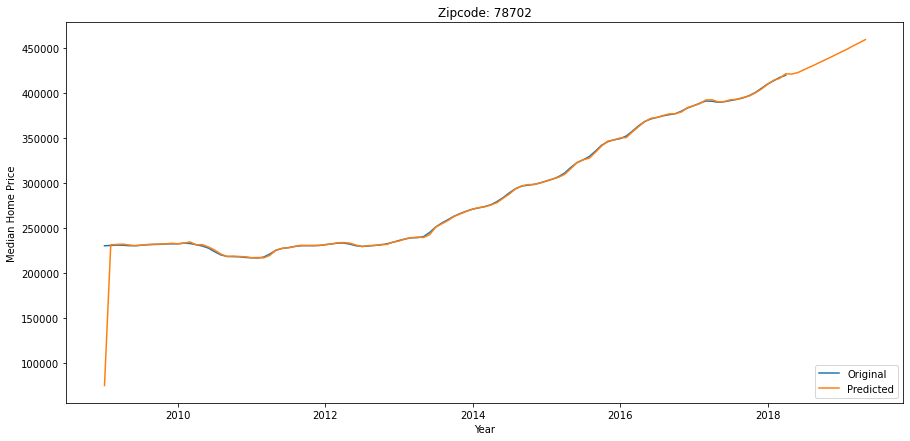

Zipcode: 78702
Explained Variance:
	 0.9508895365932697
MAE:
	 1978.6581525388426
RMSE:
	 14708.201347996577
r^2:
	 0.9504584240824365


C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



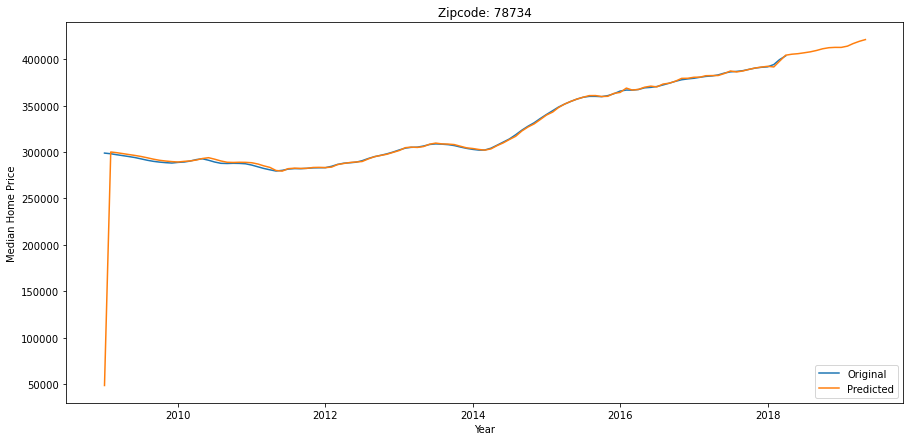

Zipcode: 78734
Explained Variance:
	 0.637928317365049
MAE:
	 3132.163732004606
RMSE:
	 23682.88383848724
r^2:
	 0.6357967175597852


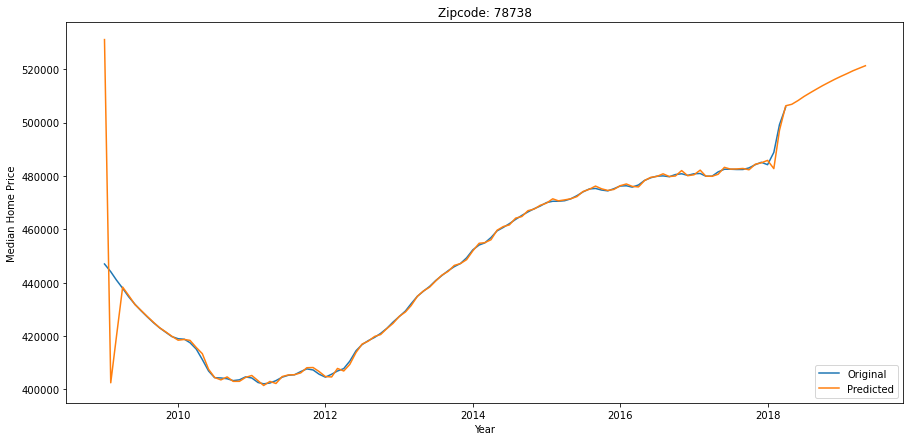

Zipcode: 78738
Explained Variance:
	 0.9101352071868873
MAE:
	 1803.8494308632964
RMSE:
	 9127.845464914879
r^2:
	 0.9100950783294066


C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.

C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



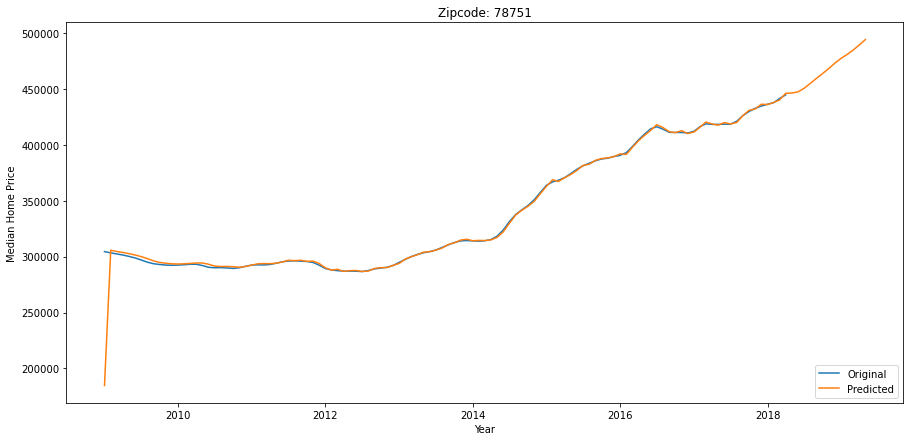

Zipcode: 78751
Explained Variance:
	 0.9548745753099757
MAE:
	 1971.3731411232675
RMSE:
	 11364.422321905946
r^2:
	 0.9547162460795551


C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.

C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



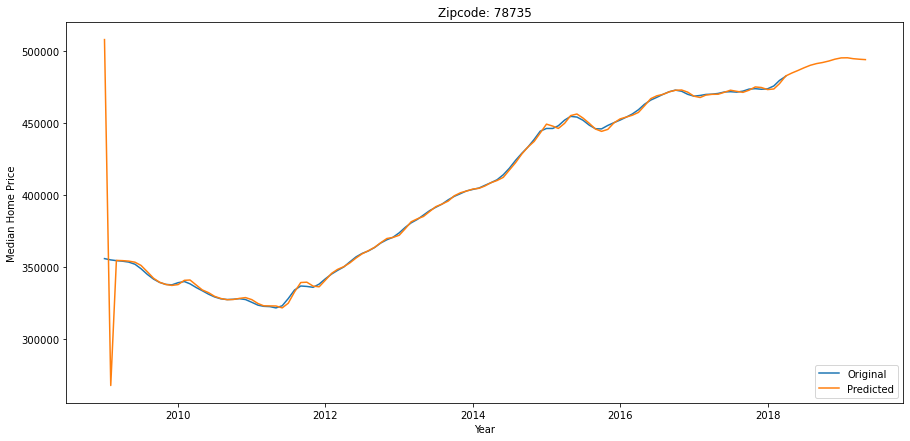

Zipcode: 78735
Explained Variance:
	 0.911056923843622
MAE:
	 3047.11043246298
RMSE:
	 16595.221028208965
r^2:
	 0.9109340255035095


C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



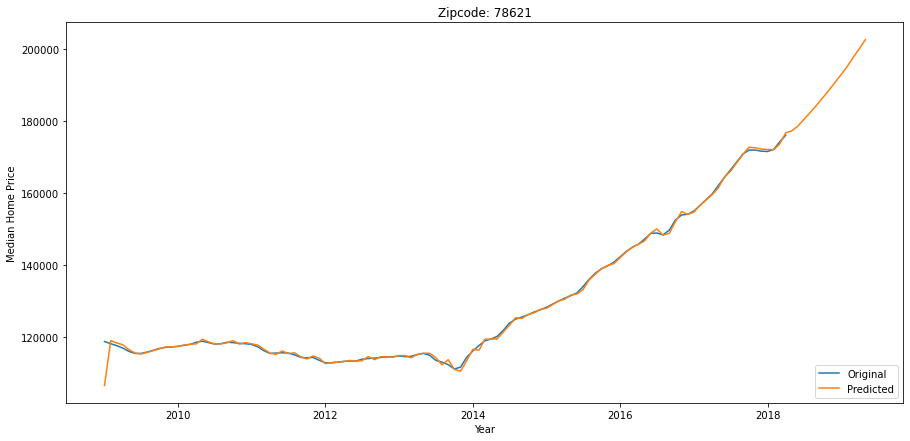

Zipcode: 78621
Explained Variance:
	 0.9957739540752014
MAE:
	 449.14480849758456
RMSE:
	 1239.4263309622597
r^2:
	 0.9957509389145548


C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



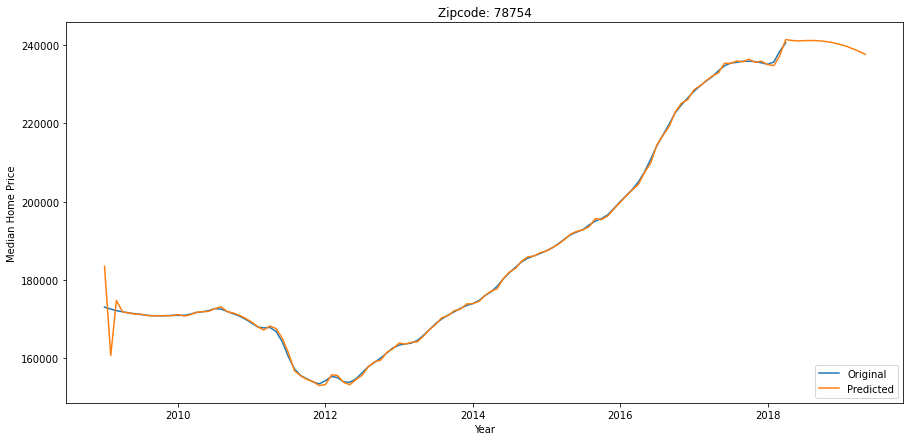

Zipcode: 78754
Explained Variance:
	 0.996385165242954
MAE:
	 494.4813087284783
RMSE:
	 1559.1341037870407
r^2:
	 0.9963850505179337


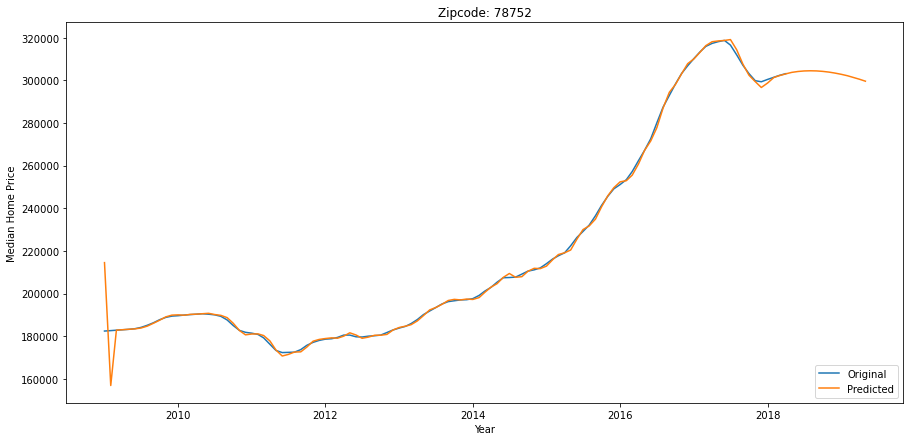

Zipcode: 78752
Explained Variance:
	 0.9930615744499807
MAE:
	 1113.9920805394115
RMSE:
	 3977.38198264135
r^2:
	 0.993061505036788


C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



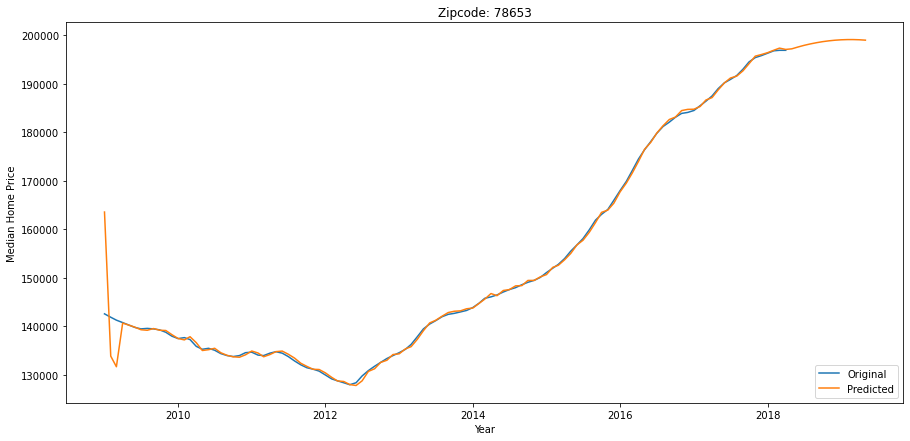

Zipcode: 78653
Explained Variance:
	 0.9882750669945634
MAE:
	 617.4849847054444
RMSE:
	 2331.7562087814335
r^2:
	 0.9882719313137011


C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



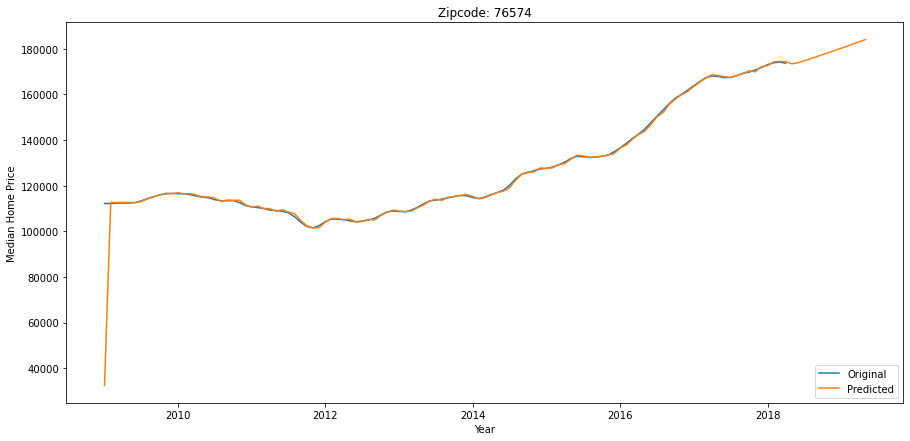

Zipcode: 76574
Explained Variance:
	 0.8827624382904837
MAE:
	 1067.5870474753099
RMSE:
	 7554.023134398777
r^2:
	 0.8817198995514758


C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



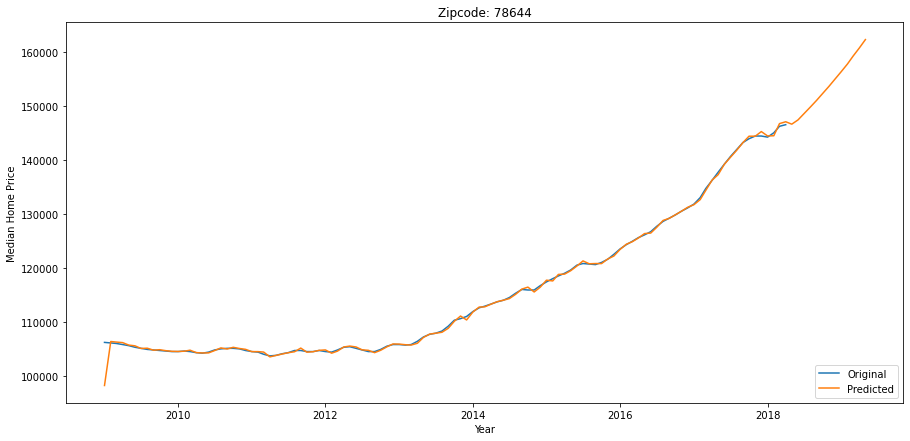

Zipcode: 78644
Explained Variance:
	 0.9962956708396922
MAE:
	 252.73152403543176
RMSE:
	 792.1299491694068
r^2:
	 0.9962745194476049


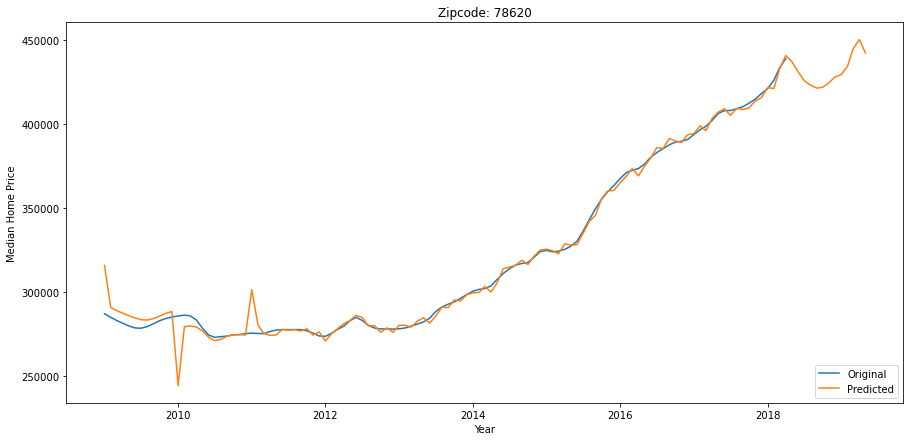

Zipcode: 78620
Explained Variance:
	 0.9863877278229807
MAE:
	 2762.1023910207045
RMSE:
	 5902.390135351228
r^2:
	 0.9863730402454928


C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.

C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



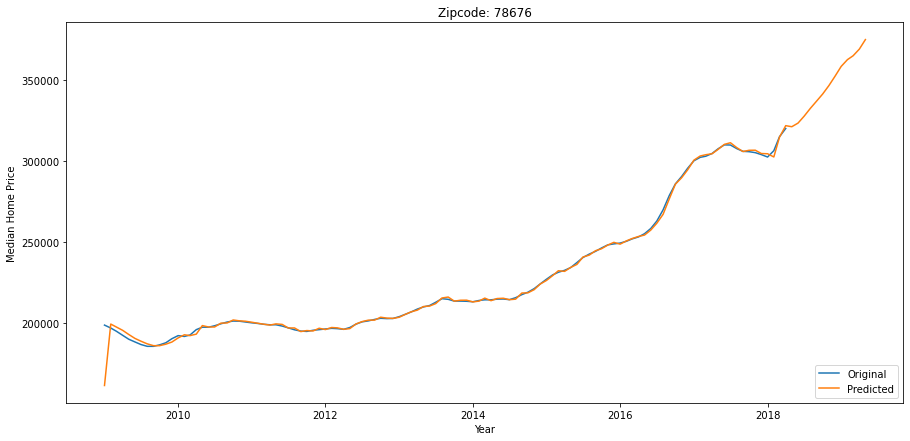

Zipcode: 78676
Explained Variance:
	 0.9915059740327294
MAE:
	 1101.6292001463833
RMSE:
	 3681.1460039662093
r^2:
	 0.9914758509347055


C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



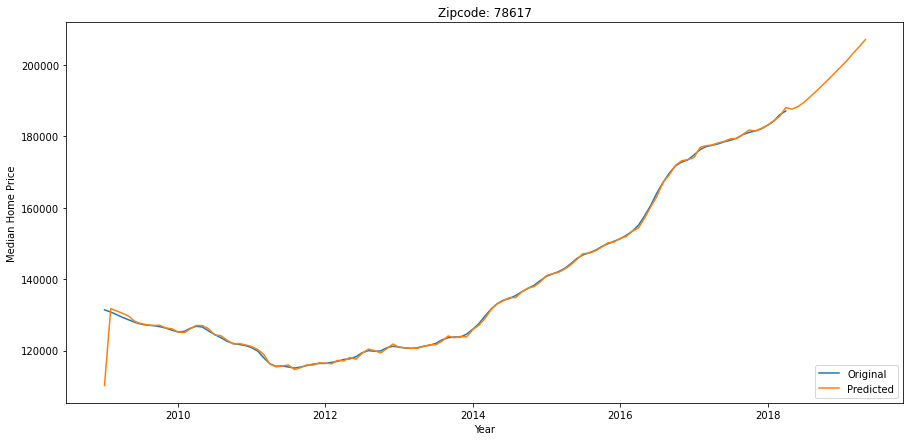

Zipcode: 78617
Explained Variance:
	 0.9915003051723774
MAE:
	 497.8756582601358
RMSE:
	 2041.7365818990656
r^2:
	 0.9914488765546521


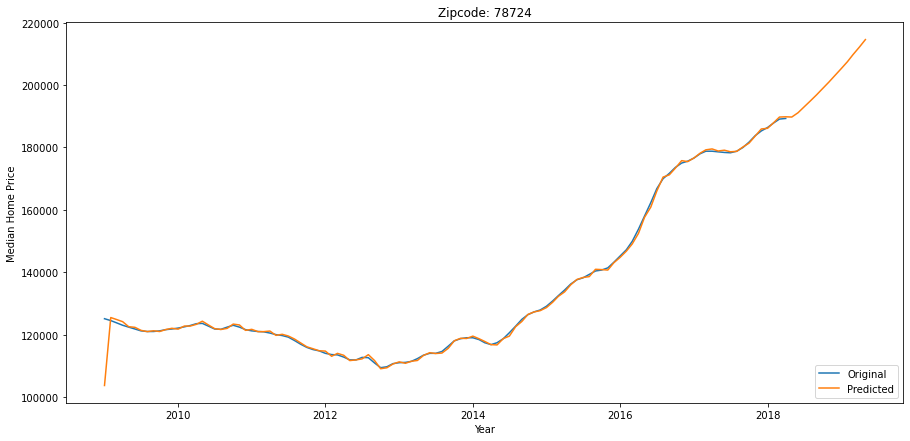

Zipcode: 78724
Explained Variance:
	 0.9928167842375882
MAE:
	 572.4878185508951
RMSE:
	 2080.828048997979
r^2:
	 0.9927704837103464


C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



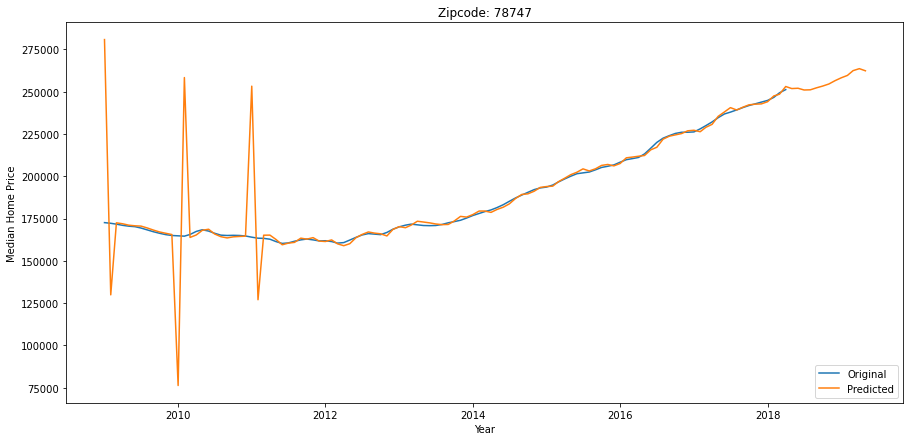

Zipcode: 78747
Explained Variance:
	 0.5358672177825089
MAE:
	 4977.881572095289
RMSE:
	 18782.12938923157
r^2:
	 0.5339758179255449


C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



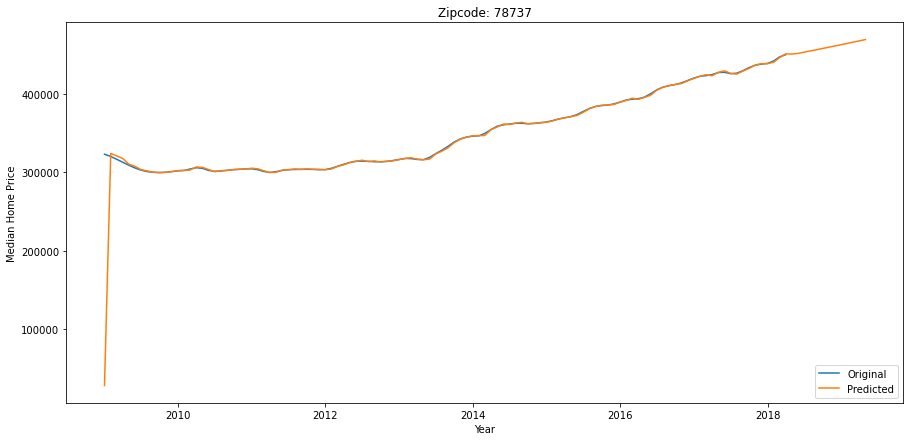

Zipcode: 78737
Explained Variance:
	 0.6612256363907644
MAE:
	 3343.5320124825635
RMSE:
	 27915.119951267065
r^2:
	 0.6583343574406826


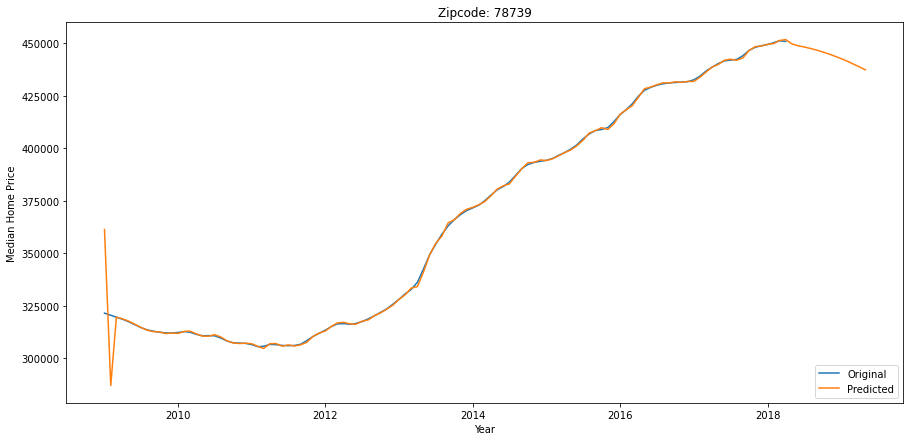

Zipcode: 78739
Explained Variance:
	 0.9910461888078549
MAE:
	 1025.445149137459
RMSE:
	 4947.651786411847
r^2:
	 0.9910461356627684


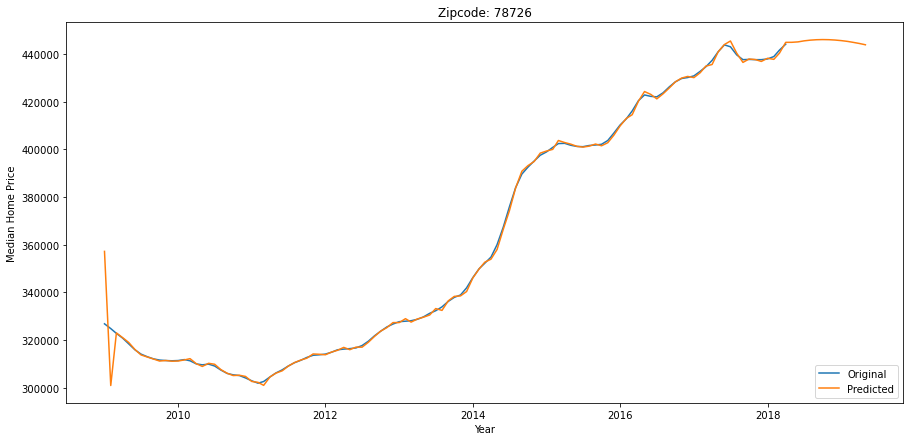

Zipcode: 78726
Explained Variance:
	 0.9946411935978198
MAE:
	 1001.0446391421054
RMSE:
	 3718.7852676304906
r^2:
	 0.9946407949204304


C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



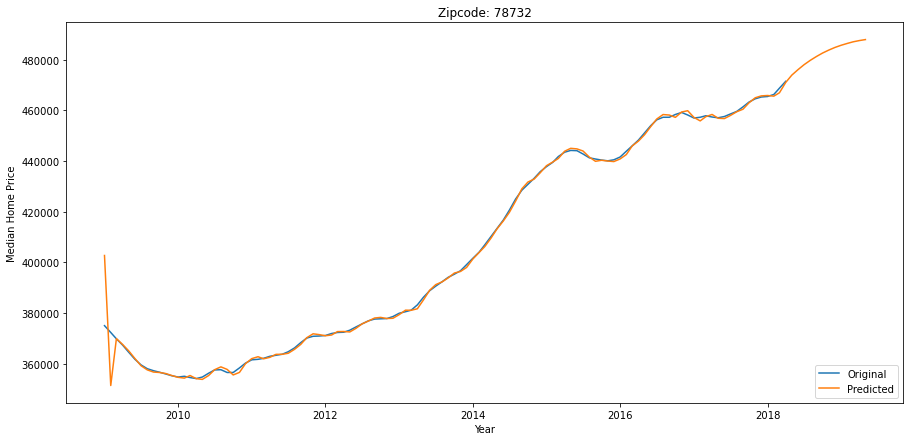

Zipcode: 78732
Explained Variance:
	 0.9931381377326439
MAE:
	 973.1898294672548
RMSE:
	 3350.611163584405
r^2:
	 0.9931362263889689


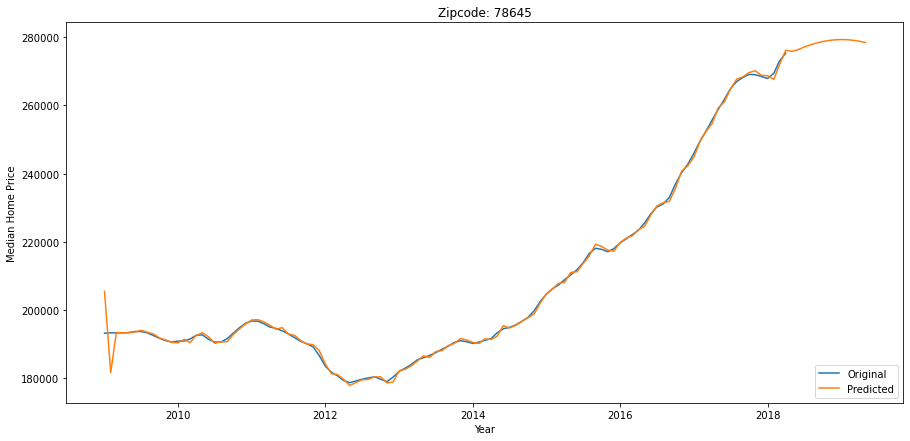

Zipcode: 78645
Explained Variance:
	 0.9960500430824581
MAE:
	 693.8487740138092
RMSE:
	 1707.4931701996438
r^2:
	 0.9960495097145252


C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



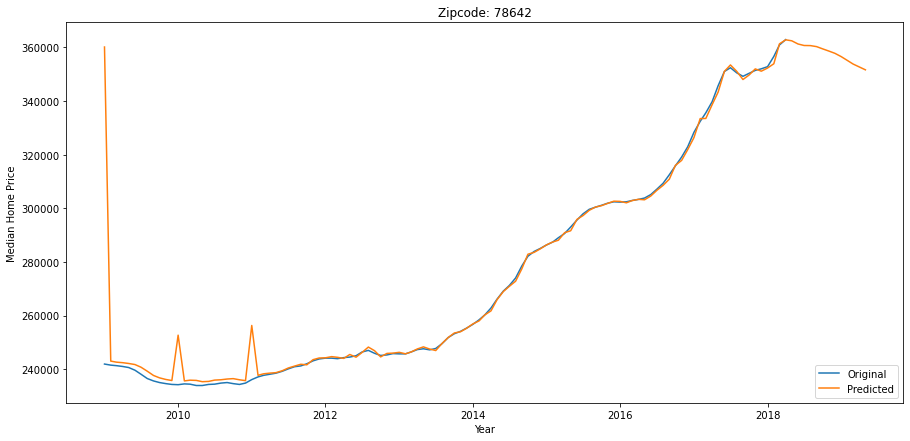

Zipcode: 78642
Explained Variance:
	 0.917961845459245
MAE:
	 2154.1888475444207
RMSE:
	 11511.206382324293
r^2:
	 0.9163679782714348


C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



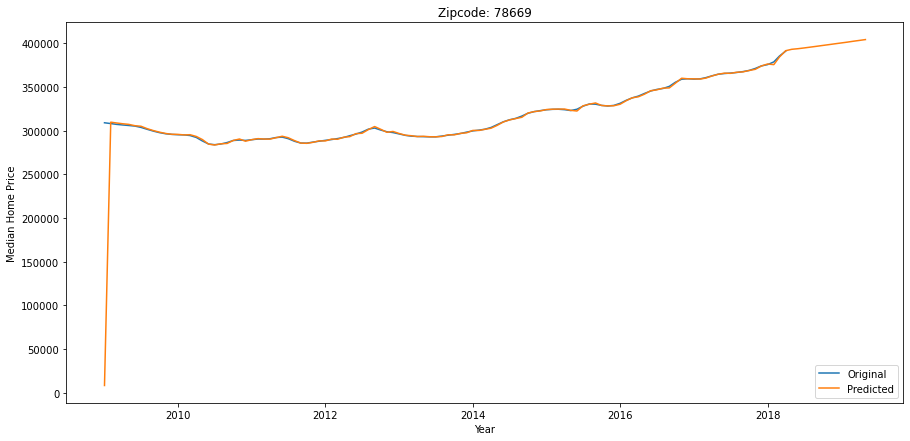

Zipcode: 78669
Explained Variance:
	 0.02408571913590085
MAE:
	 3276.346021273788
RMSE:
	 28436.733763644832
r^2:
	 0.015532765767622747


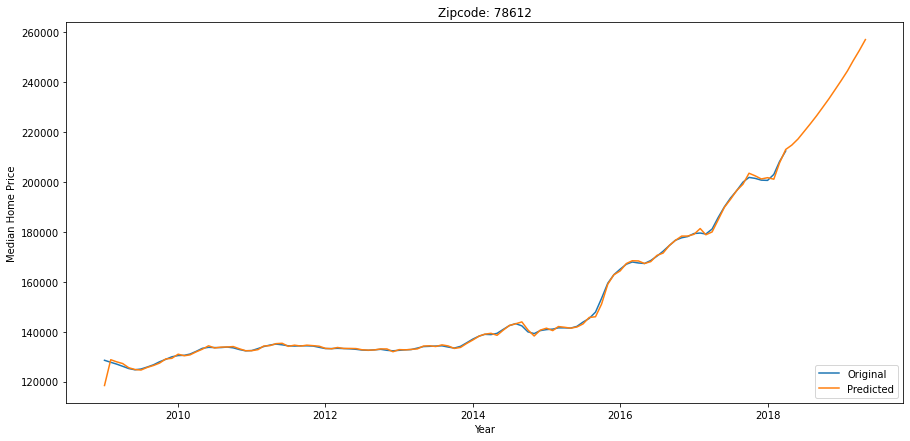

Zipcode: 78612
Explained Variance:
	 0.9975938960007829
MAE:
	 530.6142502602369
RMSE:
	 1139.4650117424737
r^2:
	 0.9975850612202437


C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



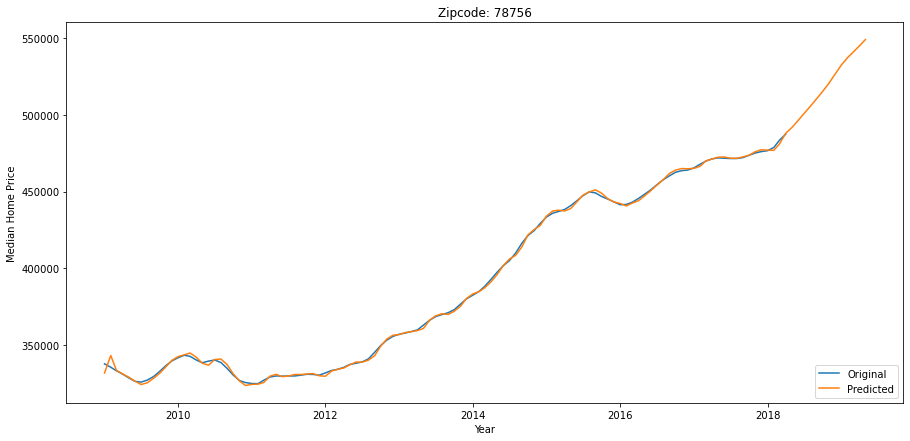

Zipcode: 78756
Explained Variance:
	 0.9993672940657634
MAE:
	 961.8104069636491
RMSE:
	 1420.1039851920805
r^2:
	 0.9993654336277613


C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.

C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



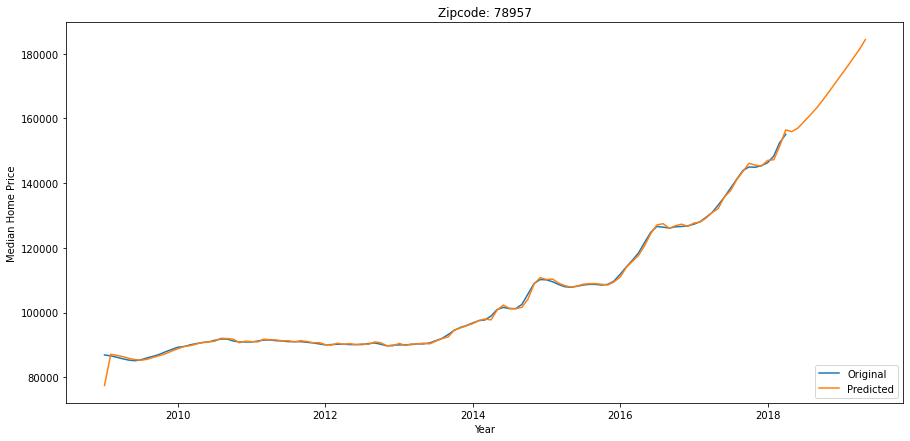

Zipcode: 78957
Explained Variance:
	 0.9970669150780075
MAE:
	 438.9838286026587
RMSE:
	 1015.2044164701438
r^2:
	 0.9970458650097321


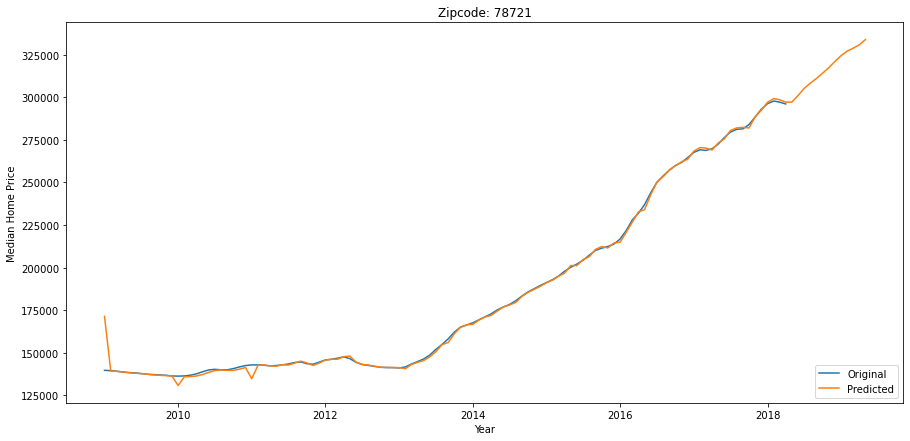

Zipcode: 78721
Explained Variance:
	 0.9962228890097717
MAE:
	 1004.0393684755545
RMSE:
	 3238.599432763917
r^2:
	 0.9962209591446612


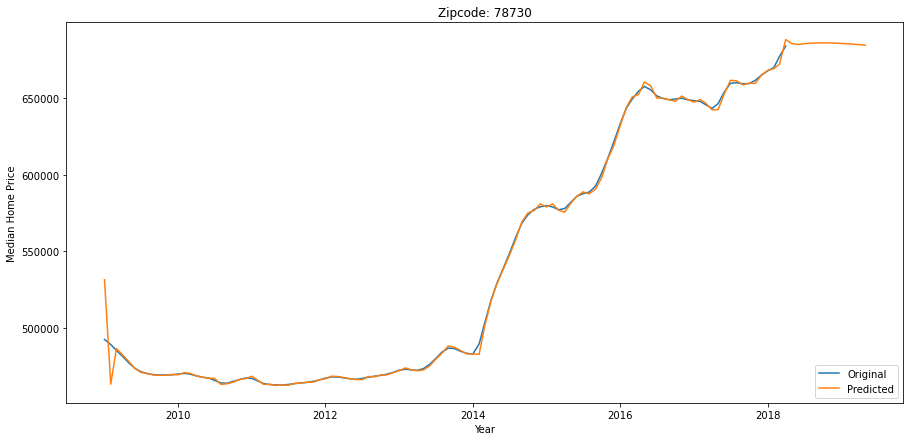

Zipcode: 78730
Explained Variance:
	 0.9965978024744855
MAE:
	 1481.9552247132112
RMSE:
	 4625.570498561946
r^2:
	 0.996597148816021


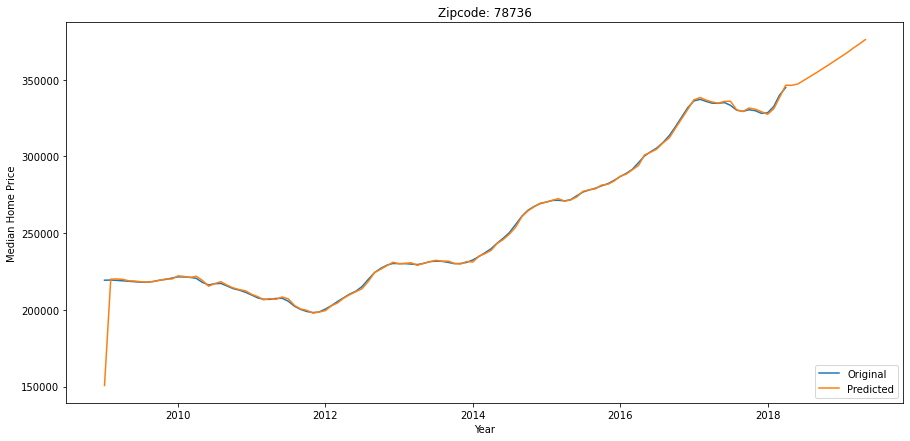

Zipcode: 78736
Explained Variance:
	 0.9795277511444925
MAE:
	 1246.6826335016844
RMSE:
	 6534.9144812653185
r^2:
	 0.9793608066143551


C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.

C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



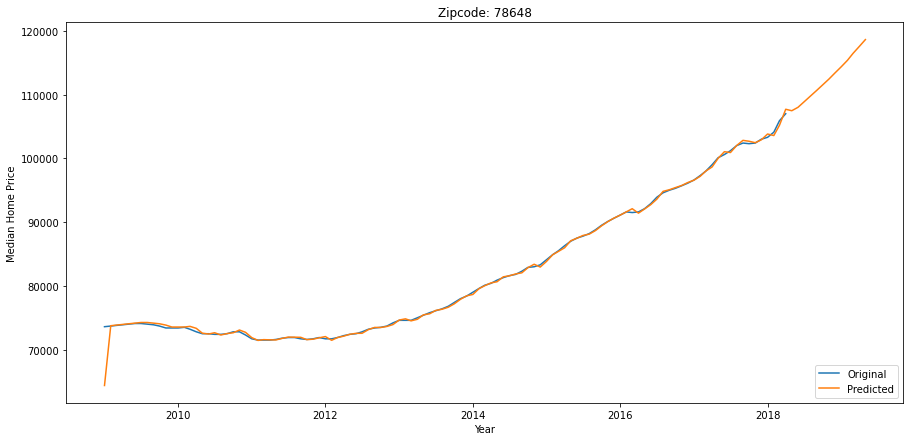

Zipcode: 78648
Explained Variance:
	 0.9929844199286761
MAE:
	 244.7439366061917
RMSE:
	 900.4845014067379
r^2:
	 0.992952864647296


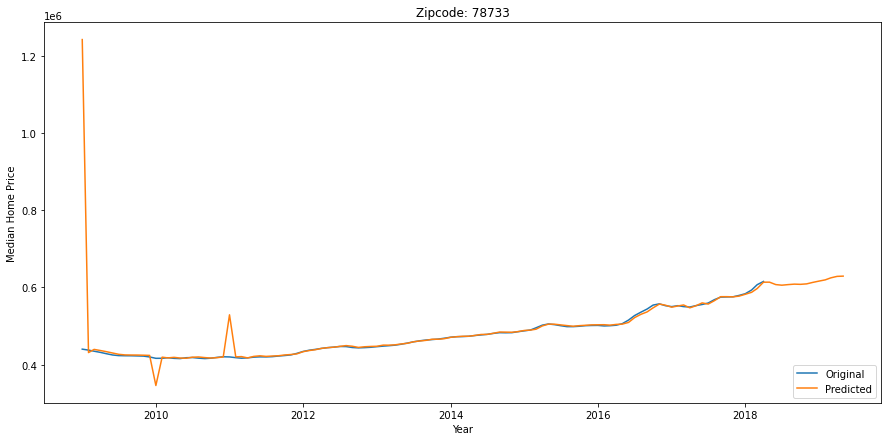

Zipcode: 78733
Explained Variance:
	 -1.0555745889840047
MAE:
	 10668.7316385364
RMSE:
	 76847.91481133277
r^2:
	 -1.0771937111466414


C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



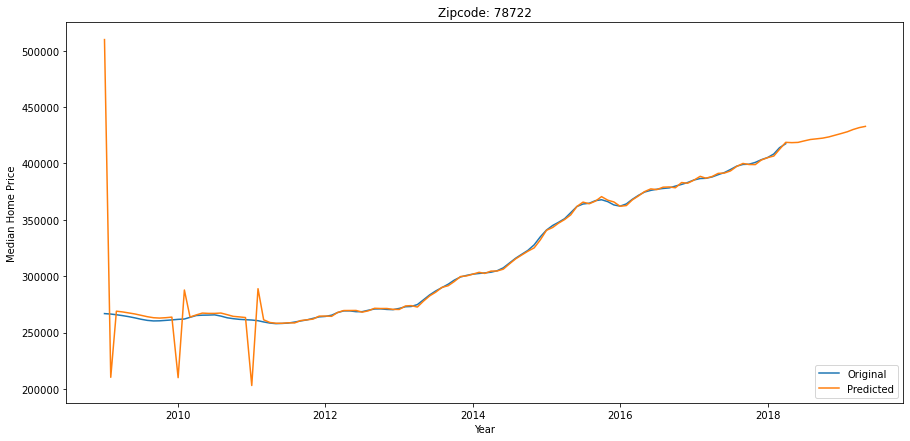

Zipcode: 78722
Explained Variance:
	 0.780009921098377
MAE:
	 5216.165646705924
RMSE:
	 24993.97924890853
r^2:
	 0.7792144779537802


C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



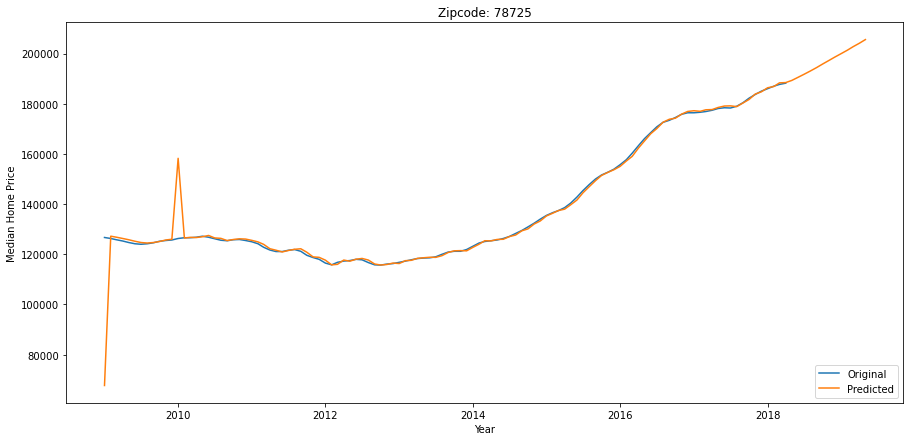

Zipcode: 78725
Explained Variance:
	 0.9253557769144681
MAE:
	 1249.4719156240467
RMSE:
	 6362.666951198762
r^2:
	 0.9253002159943025


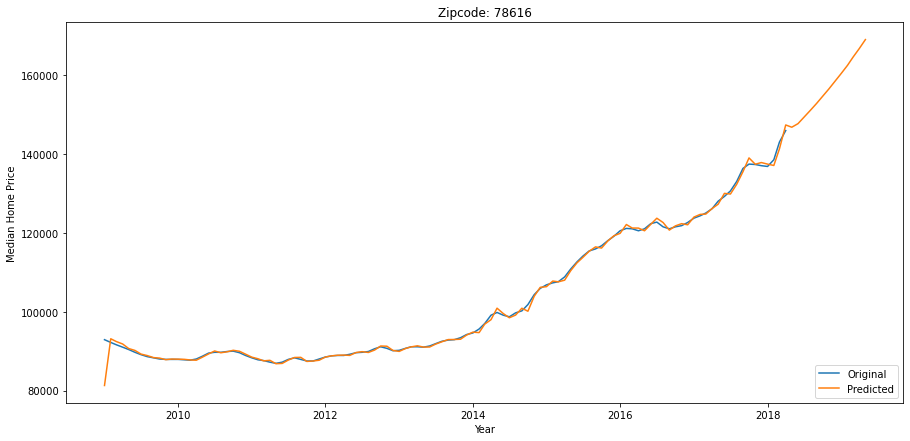

Zipcode: 78616
Explained Variance:
	 0.994763343545375
MAE:
	 497.9373237954691
RMSE:
	 1226.1998017202343
r^2:
	 0.9947361570103572


C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\pmdarima\arima\_auto_solvers.py:522: ModelFitWarning:

Error fitting  ARIMA(1,0,3)(2,0,0)[12] intercept (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\pmdarima\arima\_auto_solvers.py", line 506, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\pmdarima\arima\arima.py", line 597, in fit
    self._fit(y, X, **fit_args)
  File "C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\pmdarima\arima\arima.py", line 518, in _fit
    fit, self.arima_res_ = _fit_wrapper()
  File "C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\pmdarima\arima\arima.py", line 508, in _fit_wrapper
    return arima, arima.fit(start_params=start_params,
  File "C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\

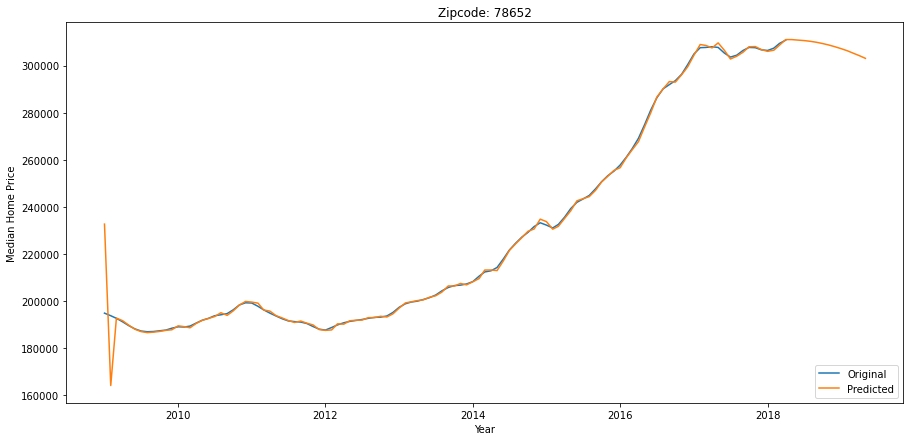

Zipcode: 78652
Explained Variance:
	 0.9888583192266223
MAE:
	 1103.8904598421163
RMSE:
	 4586.172256603588
r^2:
	 0.9888582499163071


C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



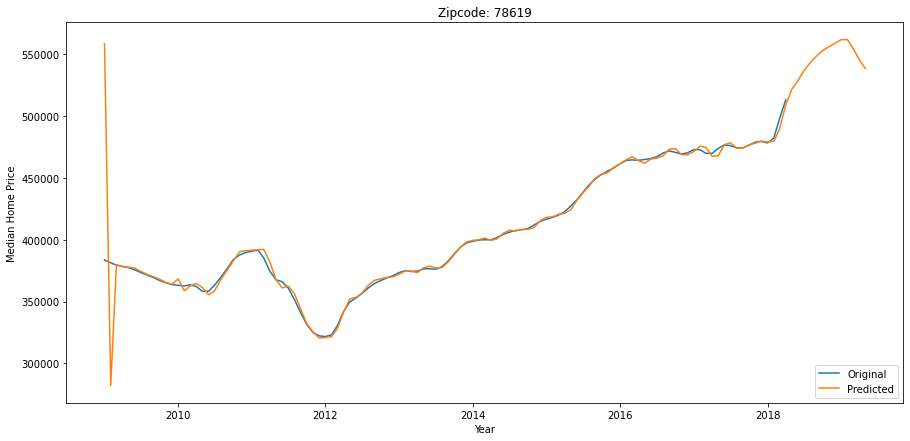

Zipcode: 78619
Explained Variance:
	 0.8414741251991295
MAE:
	 3985.293424652379
RMSE:
	 19105.054975423256
r^2:
	 0.8412302251982808


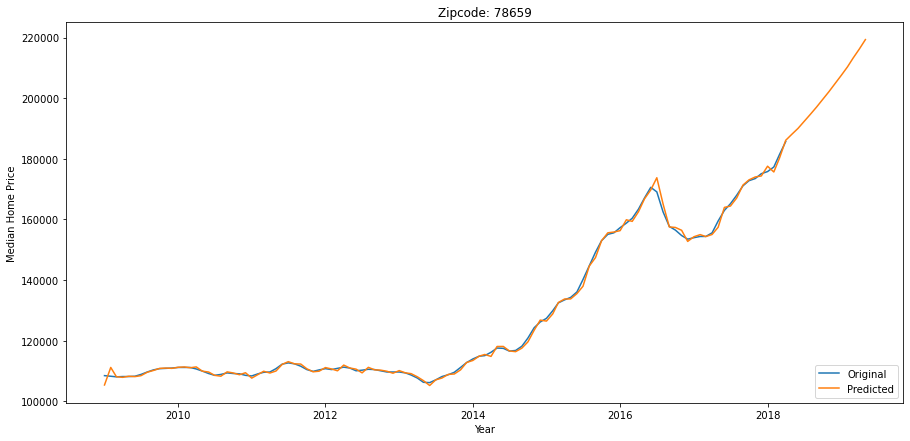

Zipcode: 78659
Explained Variance:
	 0.9984777946466531
MAE:
	 623.9152417773992
RMSE:
	 940.9832737338913
r^2:
	 0.9984734045152031


C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



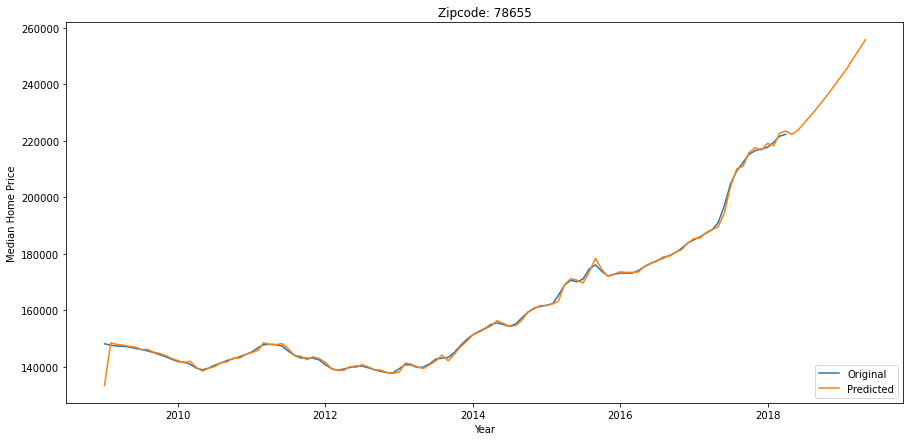

Zipcode: 78655
Explained Variance:
	 0.9954896218522252
MAE:
	 640.7856943418503
RMSE:
	 1556.5759921527172
r^2:
	 0.9954633706961866


C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



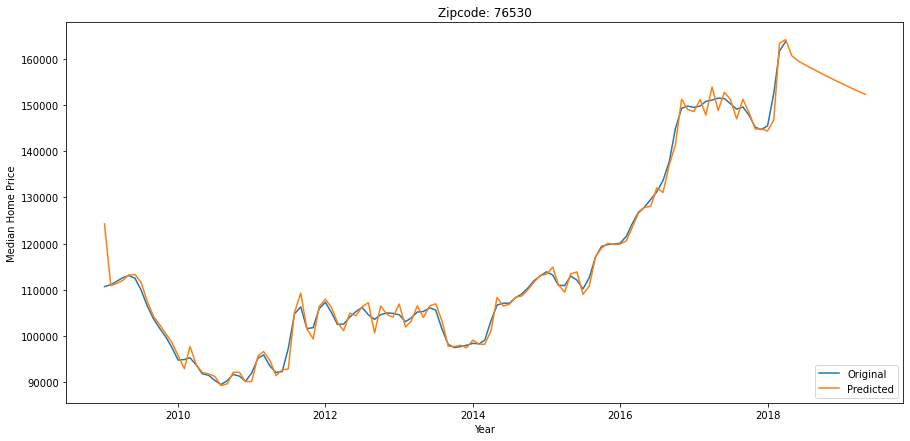

Zipcode: 76530
Explained Variance:
	 0.9900472545340401
MAE:
	 1170.3317956713083
RMSE:
	 1926.388977999094
r^2:
	 0.9900363698925218


In [141]:
for zipcode in df_final.columns:
    original_series, prediction_series = run_arima_model(df_final[zipcode], 0, 124)
    
    fig, ax = plt.subplots(figsize=(15, 7))
    plt.plot(original_series)
    plt.plot(prediction_series)
    plt.title(f'Zipcode: {zipcode}')
    plt.legend(['Original','Predicted'], loc='lower right')
    plt.xlabel('Year')
    plt.ylabel('Median Home Price')
    plt.show()
    
    print(f'Zipcode: {zipcode}')
    report_metrics(original_series, prediction_series[:-13]) 

#### Appendix: 

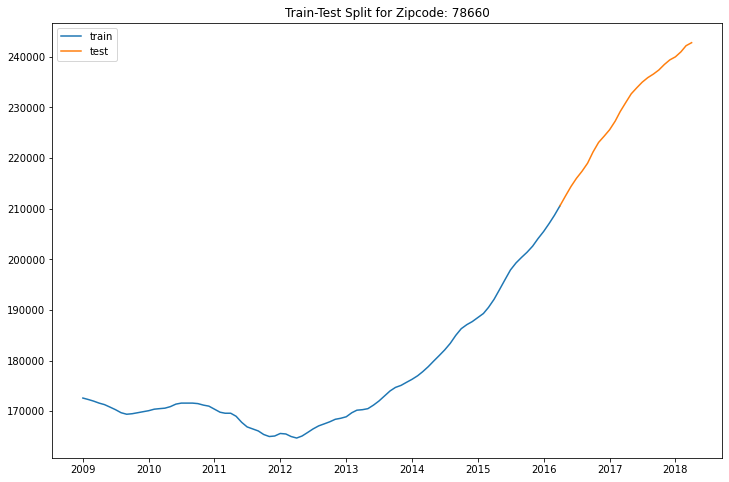

In [120]:
# Train-test split
cutoff = '2016-04-01'

# Define train and test sets according to the index found above
train = df_final[78660][:cutoff]

test = df_final[78660][cutoff:]

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(train, label='train')
ax.plot(test, label='test')
ax.set_title(f'Train-Test Split for Zipcode: 78660');
plt.legend();

In [ ]:
# time to model!
arima = pm.auto_arima(train, trace=True,start_p=0, start_q=0, start_P=0, start_Q=0,
                  max_p=20, max_q=20, max_P=20, max_Q=20, seasonal=True,maxiter=200,
                  information_criterion='aic',stepwise=False, suppress_warnings=True, D=1, max_D=10,
                  error_action='ignore',approximation = False) 

In [ ]:
arima.summary()

In [ ]:
# Plot actual test vs. forecasts:
x = np.arange(test.shape[0])
plt.plot(x, test, color='orange', label='Actual')
plt.plot(x, arima.predict(n_periods=test.shape[0]), color='green', label='Predicted')
plt.title('Actual test samples vs. forecasts')
plt.legend()
plt.show()

In [ ]:
# Import and apply seasonal_decompose()
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(train, model='additive')

# Gather the trend, seasonality, and residuals 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(train, label='Original', color='blue')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color='blue')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color='blue')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color='blue')
plt.legend(loc='best')
plt.tight_layout()


#### Exponential Smoothing: When data has trend

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [ ]:
ExpSmModel= ExponentialSmoothing(train, seasonal_periods=12, seasonal='additive',
                                           trend='additive', damped_trend=True).fit() #Taking additive trend and seasonality.

In [ ]:
# Plot actual test vs. forecasts:
x = np.arange(test.shape[0])
plt.plot(x, test, color='orange', label='Actual')
plt.plot(x, ExpSmModel.forecast(len(test)), color='green', label='Predicted')
plt.title('Actual test samples vs. forecasts')
plt.legend()
plt.show()

In [ ]:
# metrics  - Copy from TS review
from sklearn import metrics

# Note - we're back to regression metrics!
def report_metrics(y_true, y_pred):
    print("Explained Variance:\n\t", metrics.explained_variance_score(y_true, y_pred))
    print("MAE:\n\t", metrics.mean_absolute_error(y_true, y_pred))
    print("RMSE:\n\t", metrics.mean_squared_error(y_true, y_pred, squared=False))
    print("r^2:\n\t", metrics.r2_score(y_true, y_pred))
    

report_metrics(test, ExpSmModel.forecast(len(test)))

In [ ]:
# checking stationarity - copy from TS-review notebook:
from pmdarima.arima.stationarity import ADFTest
Diff_zipcodes = []
Nodiff_zipcodes = []
# beyond statsmodels
adf_test = ADFTest(alpha=0.05)
for i in df_return.columns:
    p_val, should_diff = adf_test.should_diff(np.log(df_final[i]))  # (0.01, False)

    print(f"Zipcode: {i}, P-Value: {p_val}, so should you difference the data? {should_diff}")
    
    if should_diff == True:
        Diff_zipcodes.append(i)
    else: 
        Nodiff_zipcodes.append(i)

In [ ]:
Diff_zipcodes

In [ ]:
for i in df_return.columns:
    print(f'Zipcode: {i}, Adfuller p_value: {adfuller(df_final[i])[1]}')

### Train-Test split

In [ ]:
#Copy from Scott's notebook:
for i in df_return.columns:
    cutoff = round(df_return[i].shape[0]*0.8)

    # Define train and test sets according to the index found above
    train = df_return[i][:cutoff]

    test = df_return[i][cutoff:]

    fig, ax = plt.subplots(figsize=(12, 8))
    ax.plot(train, label='train')
    ax.plot(test, label='test')
    ax.set_title(f'Train-Test Split for Zipcode: {i}');
    plt.legend();

In [ ]:
# time to model!
arima = pm.auto_arima(train, error_action='ignore', trace=True,
                      suppress_warnings=True, maxiter=100,
                      seasonal=False) 

In [ ]:
arima.summary()

In [ ]:
# Plot actual test vs. forecasts:
x = np.arange(test.shape[0])
plt.plot(x, test, color='orange', label='Actual')
plt.plot(x, arima.predict(n_periods=test.shape[0]), color='green', label='Predicted')
plt.title('Actual test samples vs. forecasts')
plt.legend()
plt.show()

In [ ]:
# metrics  - Copy from TS review
from sklearn import metrics

# Note - we're back to regression metrics!
def report_metrics(y_true, y_pred):
    print("Explained Variance:\n\t", metrics.explained_variance_score(y_true, y_pred))
    print("MAE:\n\t", metrics.mean_absolute_error(y_true, y_pred))
    print("RMSE:\n\t", metrics.mean_squared_error(y_true, y_pred, squared=False))
    print("r^2:\n\t", metrics.r2_score(y_true, y_pred))

In [ ]:
report_metrics(test, arima.predict(n_periods=test.shape[0]))

In [ ]:
# Fit an ARIMA model for each zipcode - look into parameters
for i in df_return.columns:
    arima_order = (1,1,0)
    mod_arima=ARIMA(df_return[i], order=arima_order)
    res_arima = mod_arima.fit()
    print(f'Zipcode:{i}, {res_arima.summary()}')
    print('\n')
    

# Step 5: Interpreting Results